## <center><font color=navy>Algorithmic Trading with Python</font></center>
### <center>Time Series Forecasting</center>
#### <center>Ali Habibnia</center>

In this notebook, we delve into the methodologies of forecasting univariate time series problems leveraging the primary tools available within the Python ecosystem. The Pandas library in Python offers robust built-in capabilities for time series data manipulation, while the Statsmodels module furnishes users with the tools to dissect data, estimate statistical models, and execute statistical tests.

Financial quantitative researchers aim to discern trends, seasonal fluctuations, and dependencies in historical financial datasets through the application of statistical time series techniques. The ultimate aspiration is to generate actionable trading signals. Enhancing the profitability of our trading algorithms necessitates the utilization of rigorous statistical methods to recognize consistent asset behavior, which can be harnessed for profitable opportunities. This involves a thorough examination of the temporal evolution of asset price properties.

To commence, we'll acquire the S&P 500 (^GSPC) dataset from Yahoo Finance. In this notebook, our primary objective will be the forecasting of the S&P 500 index.

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import warnings
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.stats as sms
import scipy.stats as scs
from statsmodels.tsa.stattools import coint, adfuller
warnings.filterwarnings('ignore')

In [117]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import AutoReg

In [6]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Data Preparation

### Load and Explore Time Series Data

In [7]:
# load dataset
start = datetime.datetime(2016,1,1)
end = datetime.datetime(2022,12,30)
df = yf.download("^GSPC", start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [8]:
# display first few lines of a time series
df.head()

Date
2016-01-04   2012.66
2016-01-05   2016.71
2016-01-06   1990.26
2016-01-07   1943.09
2016-01-08   1922.03
Name: Adj Close, dtype: float64

In [9]:
# Remove days (rows) with missing values
df.dropna(axis='index', how='all', inplace=True)

In [10]:
# the index is in datetime format, which is fine
df.index[:5]

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [20]:
Re = np.log(df).diff().dropna() # Re = np.log(df / df.shift(1))

Re.head()

Date
2016-01-05    0.00
2016-01-06   -0.01
2016-01-07   -0.02
2016-01-08   -0.01
2016-01-11    0.00
Name: Adj Close, dtype: float64

### Create Time Series

Pandas represents time series datasets as a Series. A Series is a one-dimensional array with a time label for each row.

In [21]:
# create a time series
ts = pd.Series(df, index=df.index)
print(ts)

Date
2016-01-04   2012.66
2016-01-05   2016.71
2016-01-06   1990.26
2016-01-07   1943.09
2016-01-08   1922.03
               ...  
2022-12-22   3822.39
2022-12-23   3844.82
2022-12-27   3829.25
2022-12-28   3783.22
2022-12-29   3849.28
Name: Adj Close, Length: 1761, dtype: float64


In [23]:
# query a dataset using a date-time index
df[:'2017'].tail(10)

Date
2017-12-15   2675.81
2017-12-18   2690.16
2017-12-19   2681.47
2017-12-20   2679.25
2017-12-21   2684.57
2017-12-22   2683.34
2017-12-26   2680.50
2017-12-27   2682.62
2017-12-28   2687.54
2017-12-29   2673.61
Name: Adj Close, dtype: float64

In [24]:
# query a dataset using a date-time index
df['2020-06':'2020-07']

Date
2020-06-01   3055.73
2020-06-02   3080.82
2020-06-03   3122.87
2020-06-04   3112.35
2020-06-05   3193.93
               ...  
2020-07-27   3239.41
2020-07-28   3218.44
2020-07-29   3258.44
2020-07-30   3246.22
2020-07-31   3271.12
Name: Adj Close, Length: 44, dtype: float64

In [25]:
# summarize the dimensions of a time series
df.size

1761

In [26]:
# calculate descriptive statistics
df.describe()

count   1761.00
mean    3112.97
std      784.31
min     1829.08
25%     2488.11
50%     2888.32
75%     3819.72
max     4796.56
Name: Adj Close, dtype: float64

### Basic Feature Engineering

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms. There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

A time series dataset must be transformed to be modeled as a supervised learning problem. We need to transform something that looks like:

time 1, value 1

time 2, value 2

time 3, value 3

into something that looks like:

input 1, output 1

input 2, output 2

input 3, output 3

### Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the current time (t). The supervised learning problem with shifted values looks as follows:

Value(t), Value(t+1)

Value(t), Value(t+1)

Value(t), Value(t+1)

In [27]:
values = pd.DataFrame(df.values)
df2 = pd.concat([values.shift(2), values.shift(1), values], axis=1)
df2.columns = ['t-2','t-1', 't']

In [28]:
df2.head()

t-2     t-1       t
0     NaN     NaN 2012.66
1     NaN 2012.66 2016.71
2 2012.66 2016.71 1990.26
3 2016.71 1990.26 1943.09
4 1990.26 1943.09 1922.03

### Rolling Window Statistics

A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous values, also called the rolling mean.

In [30]:
values = pd.DataFrame(df.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df3 = pd.concat([means, values], axis=1)
df3.columns = ['mean(t-2,t-1)', 't']
df3.head()

mean(t-2,t-1)       t
0            NaN 2012.66
1            NaN 2016.71
2        2014.68 1990.26
3        2003.48 1943.09
4        1966.67 1922.03

### Expanding Window Statistics

Another type of window that may be useful includes all previous data in the series. This is called an expanding window and can help with keeping track of the bounds of observable data.

In [31]:
values = pd.DataFrame(df.values)
window = values.expanding()

df4 = pd.concat([window.mean(), values], axis=1)
df4.columns = ['mean', 't']
df4.head()

mean       t
0 2012.66 2012.66
1 2014.68 2016.71
2 2006.54 1990.26
3 1990.68 1943.09
4 1976.95 1922.03

## Data Visualization

Time series lends itself naturally to visualization. Line plots of observations over time are popular, but there is a suite of other plots that you can use to learn more about your problem. The more you learn about your data, the more likely you are to develop a better forecasting model.

<AxesSubplot:xlabel='Date'>

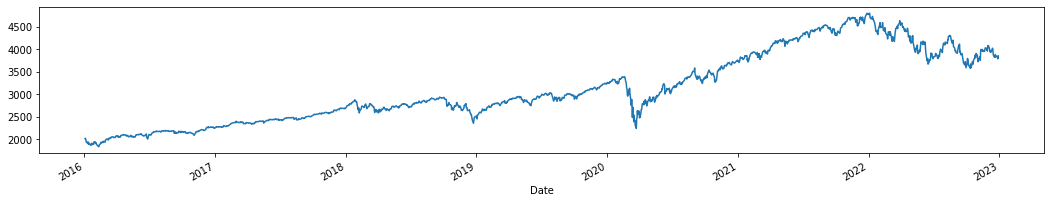

In [32]:
# Line Plot
df.plot()

<AxesSubplot:xlabel='Date'>

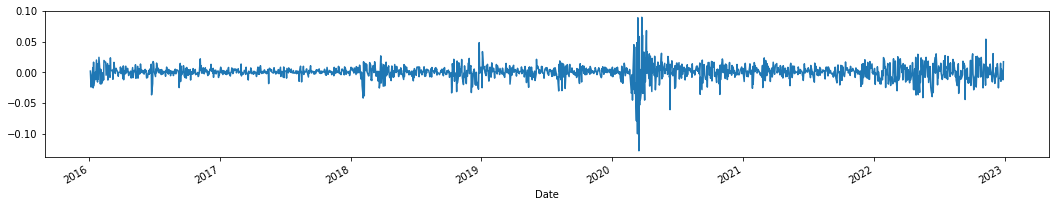

In [34]:
Re.plot()

<AxesSubplot:>

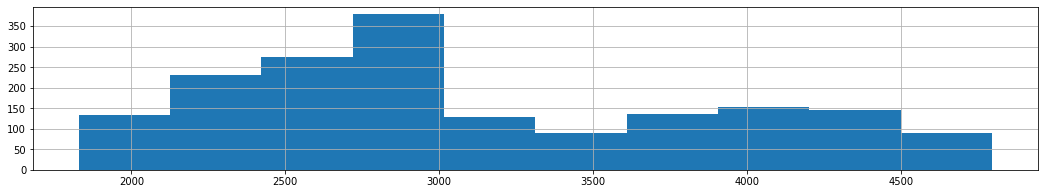

In [35]:
# Histogram and Density Plots
df.hist()

<AxesSubplot:>

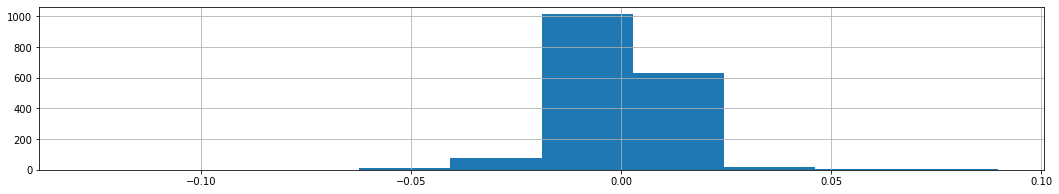

In [36]:
Re.hist()

This means a plot of the values without the temporal ordering. Some linear time series forecasting methods assume a well-behaved distribution of observations (i.e. a bell curve or normal distribution). This can be explicitly checked using tools like statistical hypothesis tests. But plots can provide a useful first check of the distribution of observations both on raw observations and after any type of data transform has been performed.



<AxesSubplot:ylabel='Density'>

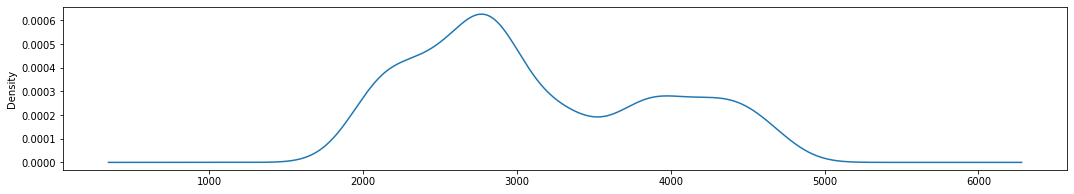

In [39]:
df.plot(kind='kde')

Kernel Density Estimation (KDE): The primary purpose of a KDE is to provide a smoothed version of the histogram, showing the general distribution of data. For time series data, this helps in understanding the distribution of values the series takes, whether it's normally distributed, skewed, etc.

### Lag Scatter Plots

Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag=1, the observation at two time steps ago lag=2, and so on. A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot. Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis and the lag=1 observation (t-1) on the y-axis.

- If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
- If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
- Either relationship is good as they can be modeled.

More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship. A ball in the middle or a spread across the plot suggests a weak or no relationship.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

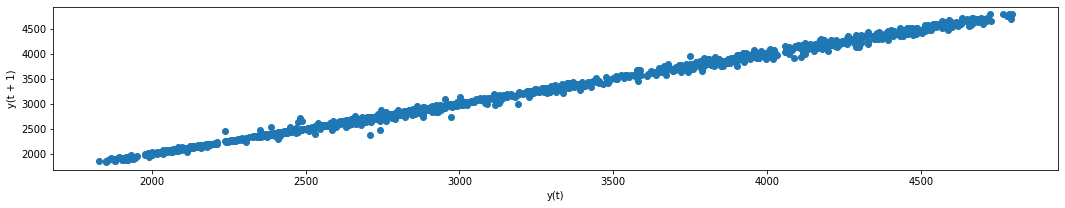

In [40]:
lag_plot(ts)

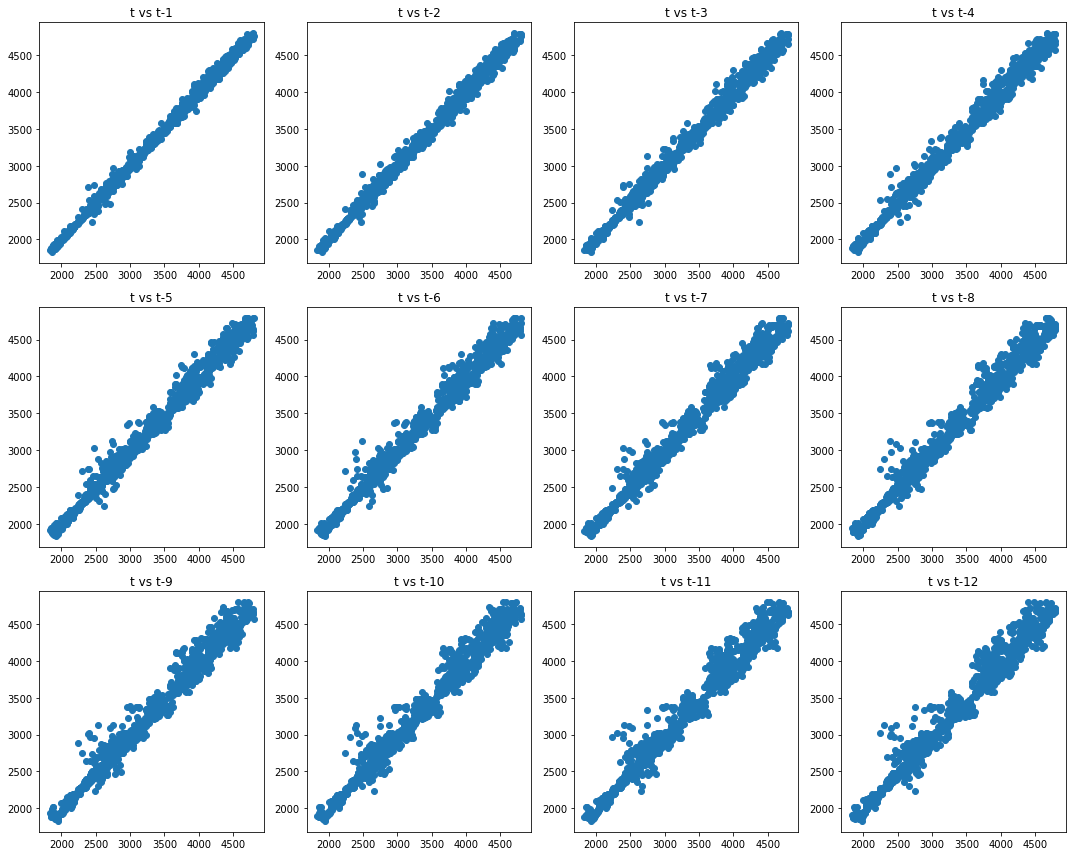

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create multiple scatter plots
values = pd.DataFrame(df.values)
lags = 12
columns = [values]

for i in range(1, (lags + 1)):
    columns.append(values.shift(i))

dff = pd.concat(columns, axis=1)

# Rename the first column as 't'
columns = ['t']
for i in range(1, (lags + 1)):
    columns.append('t-' + str(i))

dff.columns = columns

# Using GridSpec for dynamic subplot arrangement
rows = (lags + 3) // 4  # Dynamically calculate rows based on lags
gs = gridspec.GridSpec(rows, 4)
fig = plt.figure(figsize=(15,12))

for i in range(1, (lags + 1)):
    ax = fig.add_subplot(gs[(i-1) // 4, (i-1) % 4])
    ax.set_title('t vs t-' + str(i))
    ax.scatter(x=dff['t'].values, y=dff['t-'+str(i)].values)

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

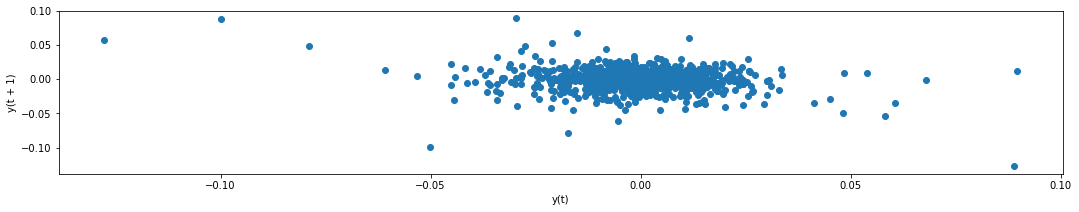

In [47]:
lag_plot(Re)

### Autocorrelation Plots

An autocorrelation plot, also known as a correlogram or ACF plot, is used to visualize the correlation of a series with its own lags. When applied to a price series in finance or any other field, it can provide insights into the following aspects:

1. **Trend**: If the price series has a strong trend, the autocorrelations for the first several lags can be significantly positive. This is because consecutive values in a trending series tend to be closer to each other than values that are further apart.

2. **Seasonality**: Regular patterns of ups and downs in the autocorrelation function can suggest seasonality in the price series. If there's a consistent pattern (e.g., a peak every 12 lags), that may indicate a yearly seasonal effect if the data is monthly.

3. **Mean Reversion**: For financial price series like stock prices, if there's a negative autocorrelation at the first or second lag, it might suggest a mean-reverting process. This could mean that upward movements are often followed by downward movements, and vice versa. This is particularly relevant in the context of strategies like pairs trading.

4. **Random Walk**: If the autocorrelation of the first lag (lag-1) is near zero and all other autocorrelations are also very close to zero, it suggests that the series might be a random walk. For stock prices, this is often the case, and the series is better described by its returns rather than its levels.

5. **Stationarity**: A sharp drop in autocorrelation after a small number of lags suggests that the series might be stationary (or has been made stationary through transformations). Non-stationary data, on the other hand, will show slow decay in the autocorrelations.

6. **Model Identification**: In the context of autoregressive (AR) and moving average (MA) models, the autocorrelation plot can help in identifying the order of the model. For instance, if the ACF of a series cuts off after `p` lags, but the partial autocorrelation function (PACF) tails off gradually, then the series can be considered an AR(p) process.

It's important to note that interpreting an autocorrelation plot requires some caution:

- Price series in finance often do not exhibit significant autocorrelation at their levels due to the efficient market hypothesis. However, their returns or changes might show patterns.
  
- A significant autocorrelation at the first few lags in the returns of a price series could indicate momentum or mean reversion.

- For non-stationary series, the autocorrelation can remain significant for several lags, giving a false impression of a relationship.

When working with financial price series, it's common to analyze the autocorrelation of returns (or logarithmic returns) instead of prices because returns are often more stationary and interpretable than raw prices.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

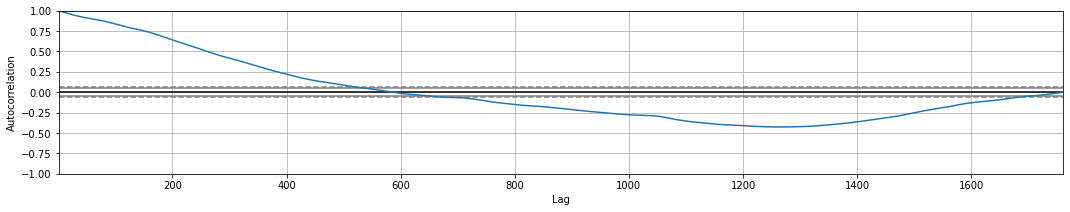

In [48]:
# create an autocorrelation plot
autocorrelation_plot(df)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

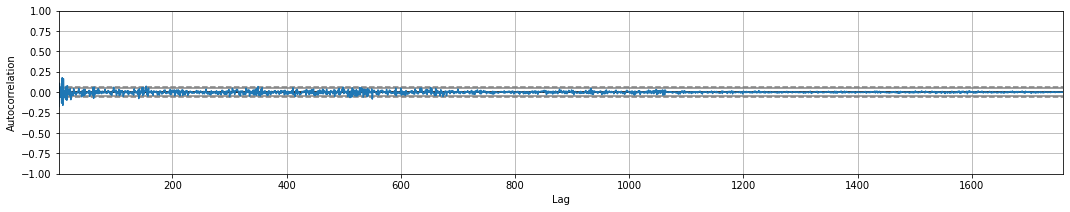

In [50]:
autocorrelation_plot(Re)

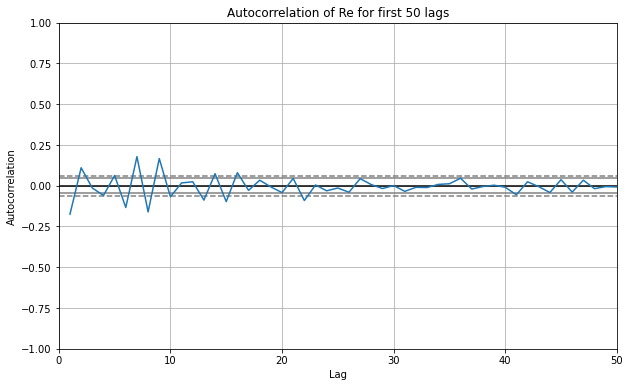

In [51]:
# Plotting the autocorrelation for the first 50 lags
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(Re)
plt.xlim([0, 50])  # Limiting the lags to 50
plt.title("Autocorrelation of Re for first 50 lags")
plt.show()


 When interpreting the ACF plot of financial returns, there are several key things to consider:

1. **Random Walk and White Noise**: For many financial time series, the raw price series (like stock prices) typically follow something close to a random walk, which means there's no correlation between consecutive values. However, when you compute returns (e.g., daily returns), the series often looks more like white noise, meaning there's no predictable pattern or trend. In an ideal white noise series, all the autocorrelations for lags greater than zero are close to zero.

2. **Significance Level**: The ACF plot usually includes horizontal lines that indicate the significance level. If autocorrelations fall within these boundaries, they are generally considered not statistically significant. If they fall outside of these boundaries, then there's evidence to suggest that the returns series is not purely random and might be autocorrelated.

3. **Short-Term Dependencies**: In some financial returns series, you might observe significant autocorrelation at the first few lags. This could be due to:
    - **Volatility Clustering**: Large changes in returns tend to be followed by large changes (either positive or negative), and small changes tend to be followed by small changes. This phenomenon is known as volatility clustering, commonly observed in financial data.
    - **Market Reaction**: Sometimes, the market might react to news or events with a delay, leading to short-term autocorrelations.

4. **Decaying Patterns**: A slow decay in the ACF plot could suggest a long memory process or a moving average (MA) process. In financial terms, this might be indicative of prolonged market reactions or trends.

5. **Seasonal Effects**: If there's a repeating spike in the ACF plot at regular intervals, this could indicate seasonality in the data. However, in financial daily returns, seasonality is relatively rare. If the data were monthly or quarterly, you might observe seasonality due to business cycles or other factors.

6. **Non-Stationarity**: If the ACF plot starts very high and decreases very slowly, this could be a sign that your series is non-stationary. Non-stationary series can present challenges in forecasting and might need to be differenced or transformed.

In summary, for financial returns, the ACF plot can provide insights into whether returns are purely random or if there are potentially exploitable patterns. It's crucial, however, to be cautious: even if patterns are detected, they might not remain consistent over time, and transaction costs or other factors can quickly erode any potential gains from strategies based on observed patterns.

The Statsmodels library also provides a version of the autocorrelation plot as a line plot. Plots lags on the horizontal and the correlations on vertical axis.

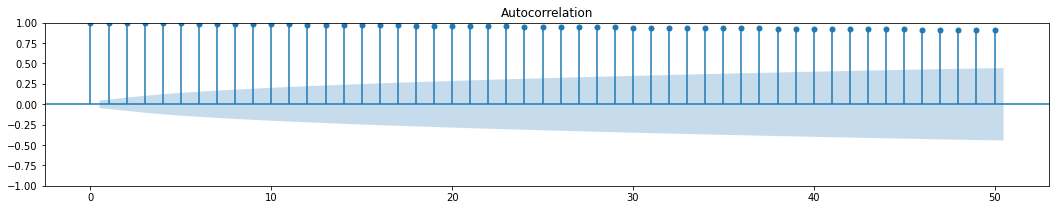

In [52]:
# autocorrelation plot of time series as a line plot
plot_acf(df, lags=50)
plt.show()

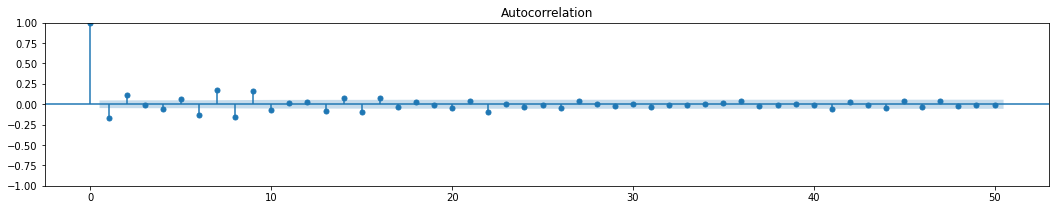

In [54]:
plot_acf(Re, lags=50)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

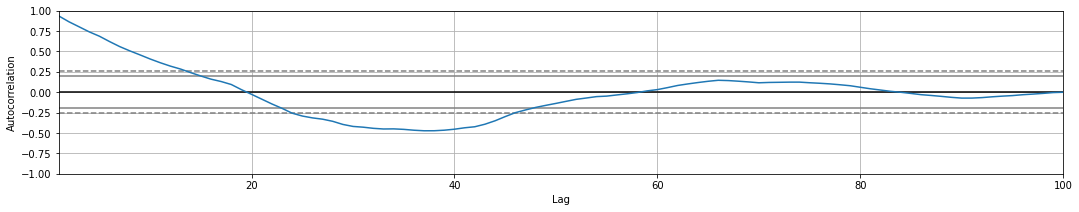

In [55]:
# create an autocorrelation plot, using only the last 100 entries
autocorrelation_plot(df[-100:])

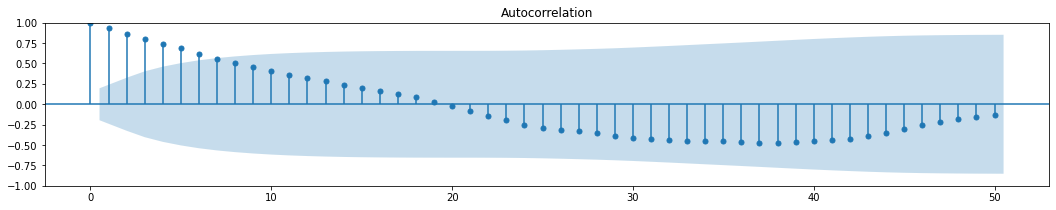

In [56]:
# autocorrelation plot of time series as a line plot
plot_acf(df[-100:], lags=50)
plt.show()

The Partial Autocorrelation Function (PACF) plot provides insights into the relationship between an observation in a time series and observations at prior time steps with the relationships of intervening observations removed.

Here's how to interpret a PACF plot:

1. **Lag Value**: The x-axis represents the lag value. For instance, a lag of 1 represents the correlation between a series and its previous value.

2. **Correlation**: The y-axis displays the value of the partial autocorrelation. It ranges from -1 to 1, similar to the correlation coefficient. A value close to 1 indicates a strong positive correlation, a value close to -1 indicates a strong negative correlation, and values close to 0 indicate little to no correlation.

3. **Confidence Intervals**: The PACF plot typically has horizontal lines drawn at the point of statistical significance. These lines represent the confidence intervals, often set at 95%. Correlation values outside of these lines are considered statistically significant.

4. **Significant Lags**: Lags at which the PACF chart crosses the upper or lower confidence interval are considered significant. These significant lags can be used as evidence to include autoregressive terms in ARIMA or AR models.

How to derive conclusions:

- **Sharp Cut-off**: If the PACF shows a sharp cutoff while the ACF decays more slowly (i.e., in a more lagged manner), it suggests using an autoregressive (AR) model of the order indicated by the last significant lag.

- **Gradual Decline**: If the PACF declines more gradually and the ACF has a sharp cut-off, it suggests a moving average (MA) model.

- **Mixed Behavior**: If both the ACF and PACF show a gradual decline, the series may be better suited to a mixed autoregressive-moving average (ARMA) model.

Remember, while the PACF plot can give insights on the potential order of autoregressive terms, it's just one piece of the puzzle. Model selection should also consider the domain knowledge, the ACF plot, and the significance of parameters in the model, among other things.

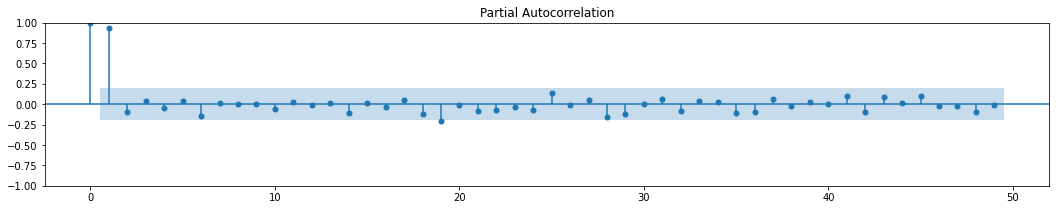

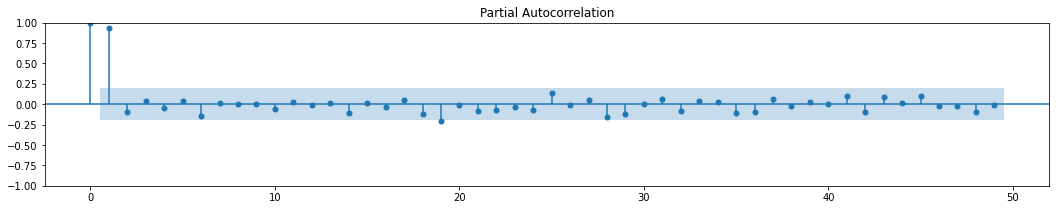

In [60]:
# partial autocorrelation plot of time series as a line plot
plot_pacf(df[-100:], lags=49)

### Moving Average Smoothing

Moving average smoothing is a naive and effective technique in time series forecasting. It can be used for data preparation, feature engineering, and even directly for making predictions. Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

In [61]:
# tail-rolling average transform
rolling = df.rolling(window=3)
rolling_mean = rolling.mean()
rolling_mean.head(10)

Date
2016-01-04       NaN
2016-01-05       NaN
2016-01-06   2006.54
2016-01-07   1983.35
2016-01-08   1951.79
2016-01-11   1929.60
2016-01-12   1928.13
2016-01-13   1917.54
2016-01-14   1916.93
2016-01-15   1897.48
Name: Adj Close, dtype: float64

<AxesSubplot:xlabel='Date'>

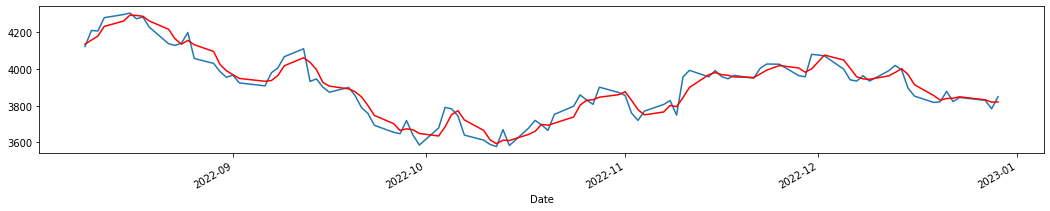

In [62]:
# plot original and transformed dataset
df[-100:].plot()
rolling_mean[-100:].plot(color='red')

### Moving Average as Prediction

The moving average value can also be used directly to make predictions. It is a naive model and assumes that the trend and seasonality components of the time series have already been removed or adjusted for. The moving average model for predictions can easily be used in a walk-forward manner. As new observations are made available (e.g. daily), the model can be updated and a prediction made for the next day.

In [63]:
# prepare problem
X = df.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [64]:
print('RMSE: %.3f' % rmse)

RMSE: 45.715


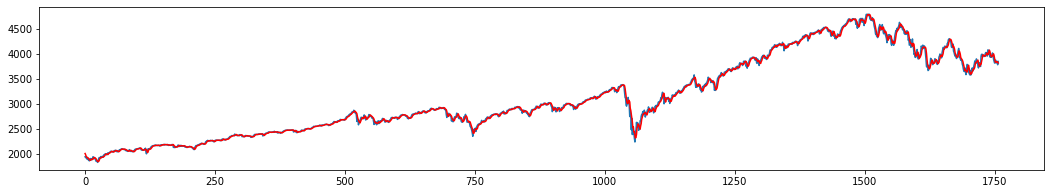

In [65]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

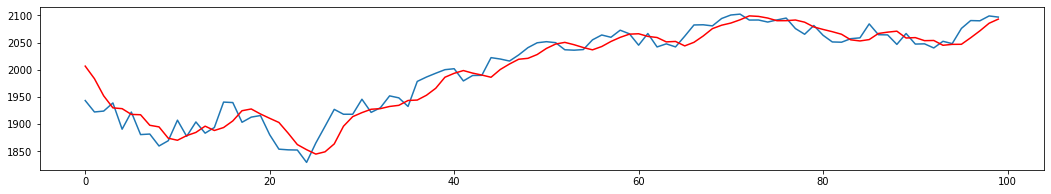

In [66]:
# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()

### Time Series Components

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

- **Systematic:** Components of the time series that have consistency or recurrence and can be described and modeled.

- **Non-Systematic:** Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. These components are defined as follows:


- **Level:** The average value in the series.

- **Trend:** The increasing or decreasing value in the series.

- **Seasonality:** The repeating short-term cycle in the series.

- **Noise:** The random variation in the series.

Our time series dataset may contain a trend. A trend is a continued increase or decrease in the series over time. There can be benefit in identifying, modeling, and even removing trend information from your time series dataset.

Time series datasets can contain a seasonal component. This is a cycle that repeats over time, such as monthly or yearly. This repeating cycle may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models. There are many types of seasonality: time of day, daily, weekly, monthly, yearly etc. Identifying whether there is a seasonality component in your time series problem is subjective. The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at different scales and with the addition of trend lines.

A time series where the seasonal component has been removed is called **seasonal stationary**. If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be **trend stationary**.

### Stationarity in Time Series Data

Data are stationary when the parameters of the data generating process do not change over time.

Mean of a time series $x_t$ is $E(x_t)=\mu(t)$

Variance of a time series $x_t$ is $\sigma^2(t)=E[(x_t - \mu(t))^2]$

A time series is stationary in the mean if $\mu(t)=\mu$, i.e.mean is constant with time

A time series is stationary in the variance if $\sigma^2(t)=\sigma^2$, i.e. variance is constant with time

Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations. When a time series is stationary, it can be easier to model. 

Statistical modeling methods assume or require the time series to be stationary to be effective. Many statistical tests, deep down in the fine print of their assumptions, require that the data being tested are stationary. A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.

#### Check for Stationarity

There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

- ***Look at Plots:*** You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.

- *** Summary Statistics:*** You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.

- *** Statistical Tests:*** You can use statistical tests to check if the expectations of stationarity are met or have been violated.

In [67]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

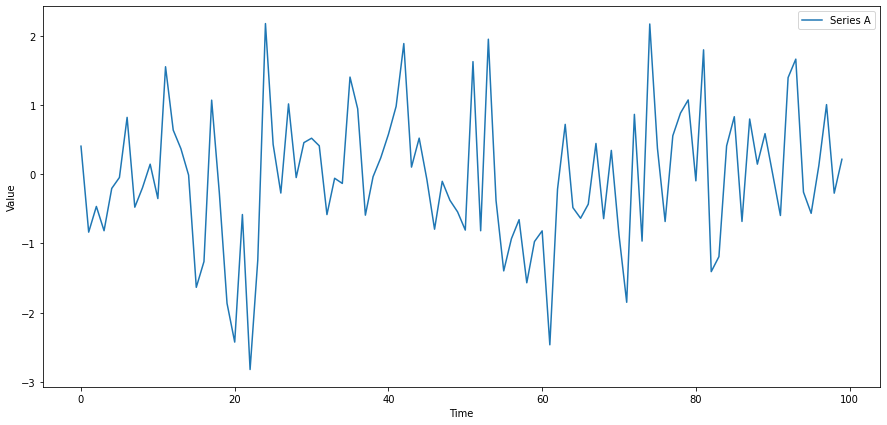

In [68]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A'])
plt.show()

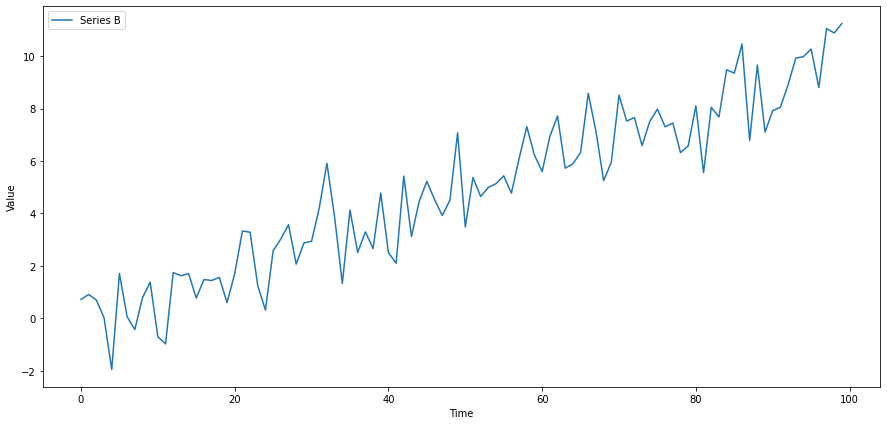

In [69]:
# Set the number of datapoints
T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B'])
plt.show()

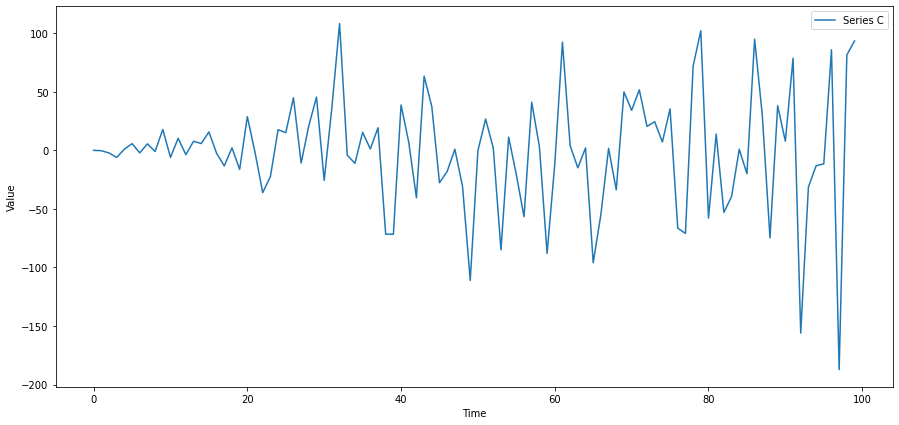

In [71]:
# Set the number of datapoints
T = 100

C = pd.Series(index=range(T))
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = ( 0,t * 1)
    C[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C'])
plt.show()

Series A is generated from a stationary process with fixed parameters, series B and C are generated with parameters that change over time.

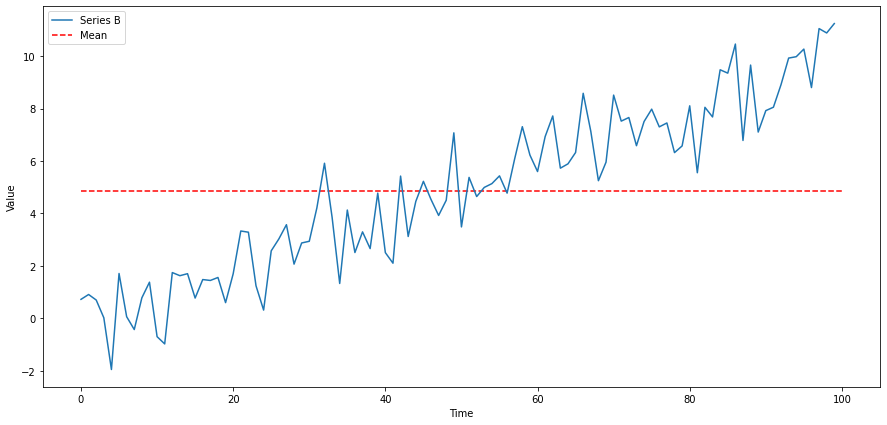

In [72]:
m = np.mean(B)
plt.figure(figsize=(15,7))
plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])
plt.show()

The computed mean will show the mean of all data points till date, but won't be useful for any forecasting of future state. It's meaningless when compared with any specfic time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can screw with analysis, much more subtle problems can arise in practice.

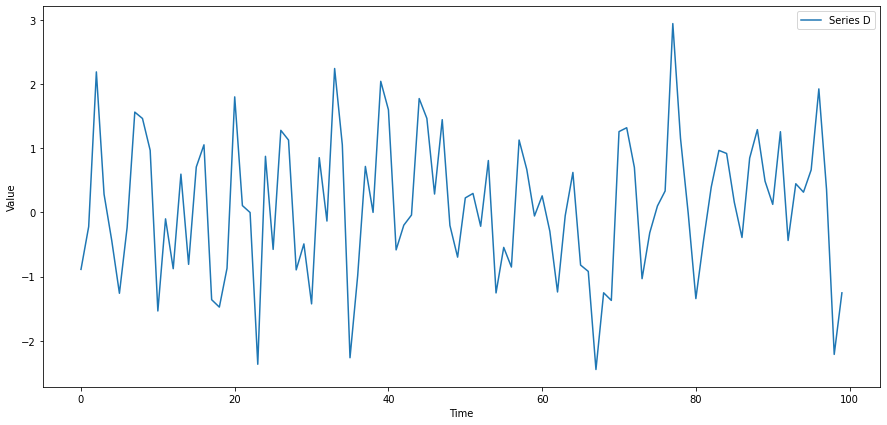

In [73]:
# Set the number of datapoints
T = 100

D = pd.Series(index=range(T))
D.name = 'D'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    D[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(D)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series D'])
plt.show()

A cyclic movement of the mean will be very difficult to tell apart from random noise. In practice on noisy data and limited sample size it can be hard to determine if a series is stationary and whether any drift is random noise or part of a trend. In each individual case the test may or may not pick up subtle effects like this.

## Augmented Dickey-Fuller test

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [84]:
# calculate stationarity test of price data
X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.383278
p-value: 0.590266
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [85]:
# calculate stationarity test of return data
X = Re
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.160572
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


We can see that our statistic value of -14.536258 is less than the value of -2.862 at 5%. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

## Cointegration

Now that we've discussed stationarity and order of integration, we can discuss cointegration.

A linear combination of the time series ($X_1$, $X_2$, $\dots$, $X_k$) is a new time series $Y$ constructed as follows for any set of real numbers $b_1 \dots b_k$

$$Y = b_1X_1 + b_2X_2 + \dots + b_kX_k$$

For some set of time series ($X_1$, $X_2$, $\dots$, $X_k$), if all series are $I(1)$, and some linear combination of them is $I(0)$, we say the set of time series is cointegrated.

For example, $X_1$, $X_2$, and $X_3$ are all $I(1)$, and $2X_1 + X_2 + 0X_3 = 2X_1 + X_2$ is $I(0)$. In this case the time series are cointegrated.

### Intuition

The intuition here is that for some linear combination of the series, the result lacks much auto-covariance and is mostly noise. This is useful for cases such as pairs trading, in which we find two assets whose prices are cointegrated. Since the linear combination of their prices $b_1A_1 + b_2A_2$ is noise, we can bet on the relationship $b_1A_1 + b_2A_2$ mean reverting and place trades accordingly. 

Let's make some data to demonstrate this.

In [88]:
# Length of series
N = 100

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# Make an X2 that is X1 plus some noise
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

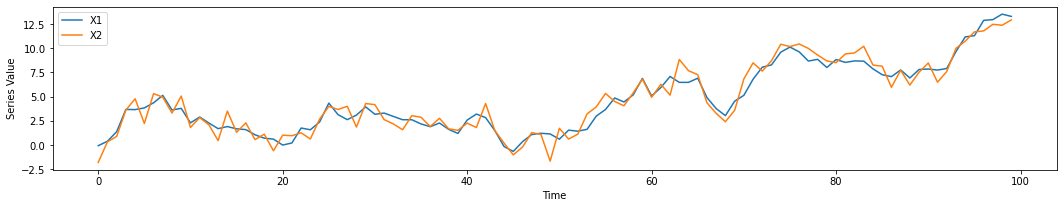

In [89]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name])
plt.show()

Because $X_2$ is just an $I(1)$ series plus some stationary noise, it should still be $I(1)$. Let's check this. Now to show cointegration we'll need to find some linear combination of $X_1$ and $X_2$ that is stationary. We can take $X_2-X_1$. All that's left over should be stationary noise by design. Let's check this.

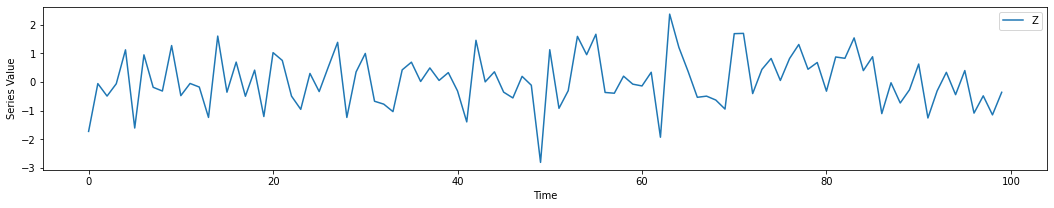

In [90]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['Z'])
plt.show()

## Evaluate Models

The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross-validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.

In time series forecasting, this evaluation of models on historical data is called backtesting. We will look at three different methods that you can use to backtest your machine learning models on time series problems:

1. Train-Test split that respects temporal order of observations.
2. Multiple Train-Test splits that respect temporal order of observations.
3. Walk-Forward Validation where a model may be updated each time step new data is received.

In [91]:
# calculate a train-test split of a time series dataset
X = Re
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [92]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 1760
Training Observations: 1161
Testing Observations: 599


## Persistence Model for Forecasting

Establishing a baseline is essential on any time series forecasting problem. A baseline in performance gives you an idea of how well all other models will actually perform on your problem. Here we will develop a persistence forecast that we can use later as a baseline level of performance on this time series dataset.

The following steps are required:

1. Transform the univariate dataset into a supervised learning problem.
2. Establish the train and test datasets for the test harness.
3. Define the persistence model.
4. Make a forecast and establish a baseline performance.
5. Review the complete example and plot the output.

In [93]:
# Create lagged dataset
values = pd.DataFrame(Re.values)
Re2 = pd.concat([values.shift(1), values], axis=1)
Re2.columns = ['t', 't+1']
Re2 = Re2[1:]
Re2.head()

t   t+1
1  0.00 -0.01
2 -0.01 -0.02
3 -0.02 -0.01
4 -0.01  0.00
5  0.00  0.01

In [94]:
# split into train and test sets
X = Re2.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [95]:
# persistence model
def model_persistence(x):
    return x

In [96]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [97]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.017


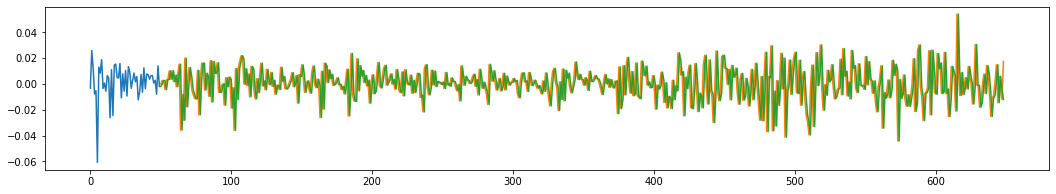

In [98]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions])

## Visualize Residual Forecast Errors

Forecast errors on a time series forecasting problem are called residual errors or residuals. A residual error is calculated as the expected outcome minus the forecast. Careful exploration of residual errors on your time series prediction problem can tell you a lot about your forecast model and even suggest improvements.

The first plot is to look at the residual forecast errors over time as a line plot. We would expect the plot to be random around the value of 0 and not show any trend or cyclic structure.

In [99]:
# calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

<AxesSubplot:>

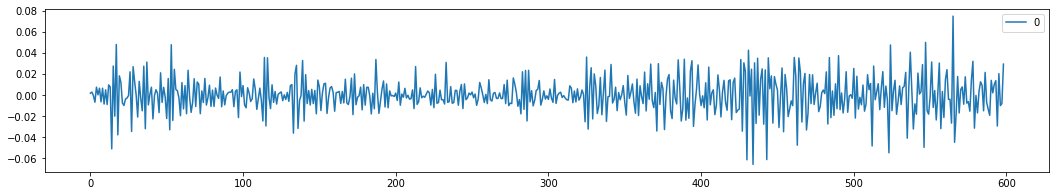

In [100]:
# plot residuals
residuals.plot()

We can calculate summary statistics on the residual errors. Primarily, we are interested in the mean value of the residual errors. A value close to zero suggests no bias in the forecasts, whereas positive and negative values suggest a positive or negative bias in the forecasts made. It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior to their use or evaluation.

In [101]:
residuals.describe()

0
count 599.00
mean    0.00
std     0.02
min    -0.07
25%    -0.01
50%    -0.00
75%     0.01
max     0.07

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

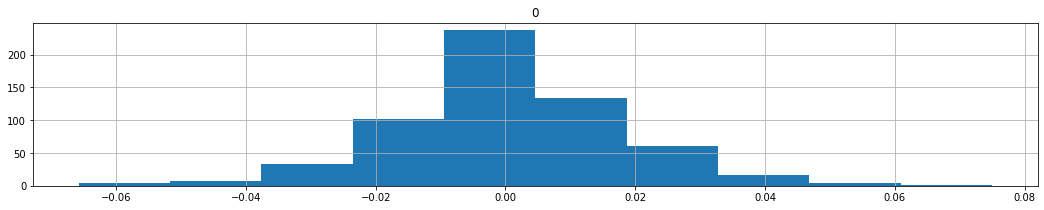

In [102]:
residuals.hist()

<AxesSubplot:ylabel='Density'>

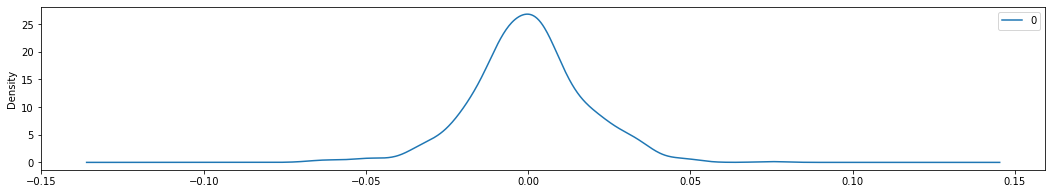

In [103]:
residuals.plot(kind='kde')

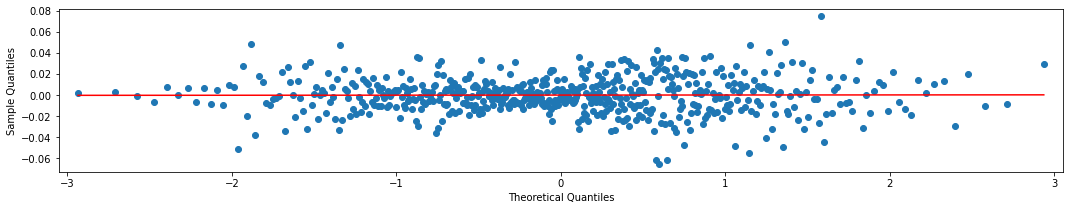

In [104]:
qqplot(residuals, line='r')
plt.show()

### Residual Autocorrelation Plot

We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being below the threshold of significance (dashed and dotted horizontal lines on the plot). A significant autocorrelation in the residual plot suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called autoregression.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

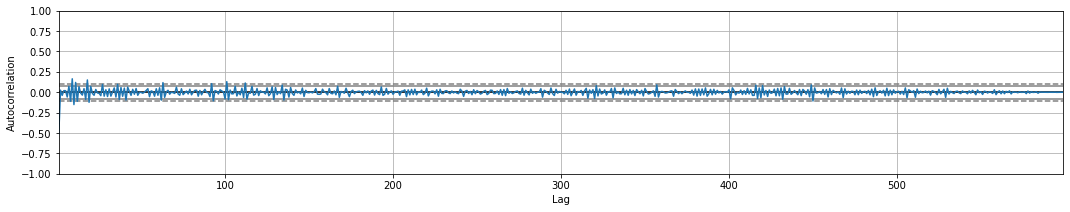

In [105]:
autocorrelation_plot(residuals)

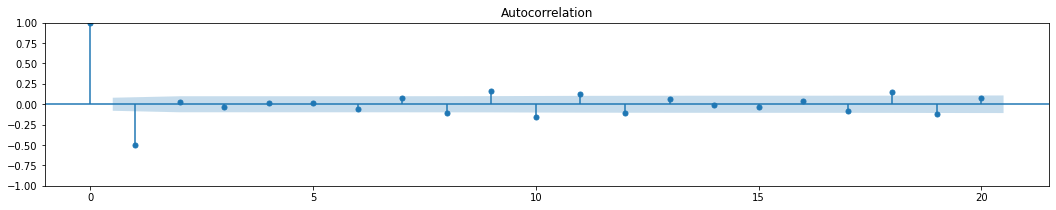

In [106]:
# autocorrelation plot of residuals as a line plot
plot_acf(residuals, lags=20)
plt.show()

## Random Walk

A random walk is a time series model where the value of the time series variable increases or decreases (step up or down) with equal probability at each time step, that is the expected value of current observation is equal to the previous observation. It is formally defined below:

$$x_t=x_{t-1}+w_t$$

, where $w_t$ is a discrete white noise series. $$E[x_t]=x_{t-1}$$

This means if the TS we are modeling is a random walk it is unpredictable, as they are literally random walks.
The significance of a random walk is that it is non-stationary because while the mean of a random walk is still zero, the covariance is actually time-dependent. In particular, the covariance is equal to the variance multiplied by the time. Hence, as time increases, so does the variance.

Let's simulate a random walk

In [107]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

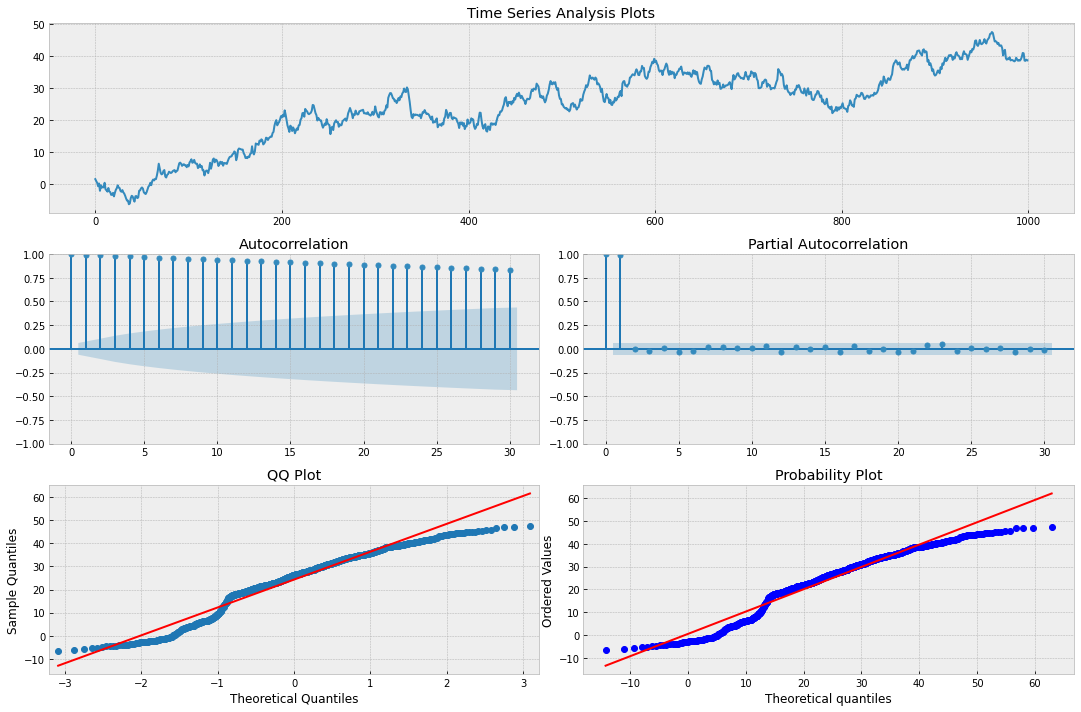

In [108]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Clearly our TS is not stationary. How to check if the random walk model is a good fit for our simulated data? We have

$$x_t - x_{t-1} = w_t$$

, where $w_t$ is a discrete white noise series.
The first differences of our random walk series should equal a white noise process!

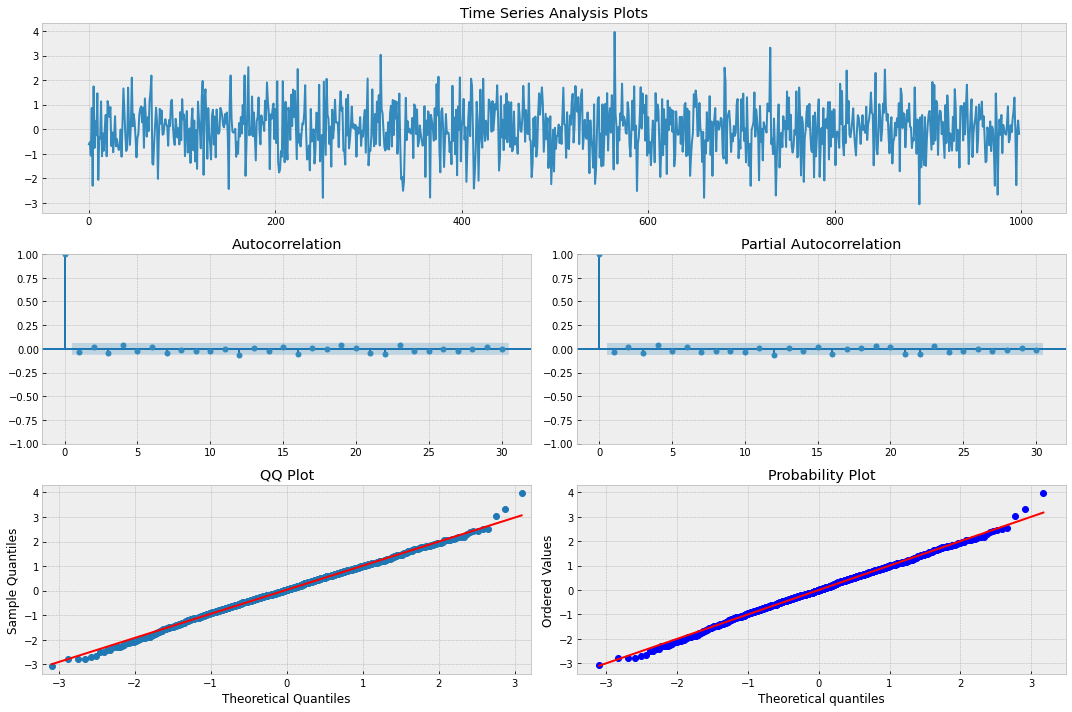

In [109]:
# First difference of simulated Random Walk series
_ = tsplot(np.diff(x), lags=30)

As expected, the difference is indeed white noise.
Let's now apply our random walk model to some actual financial data.

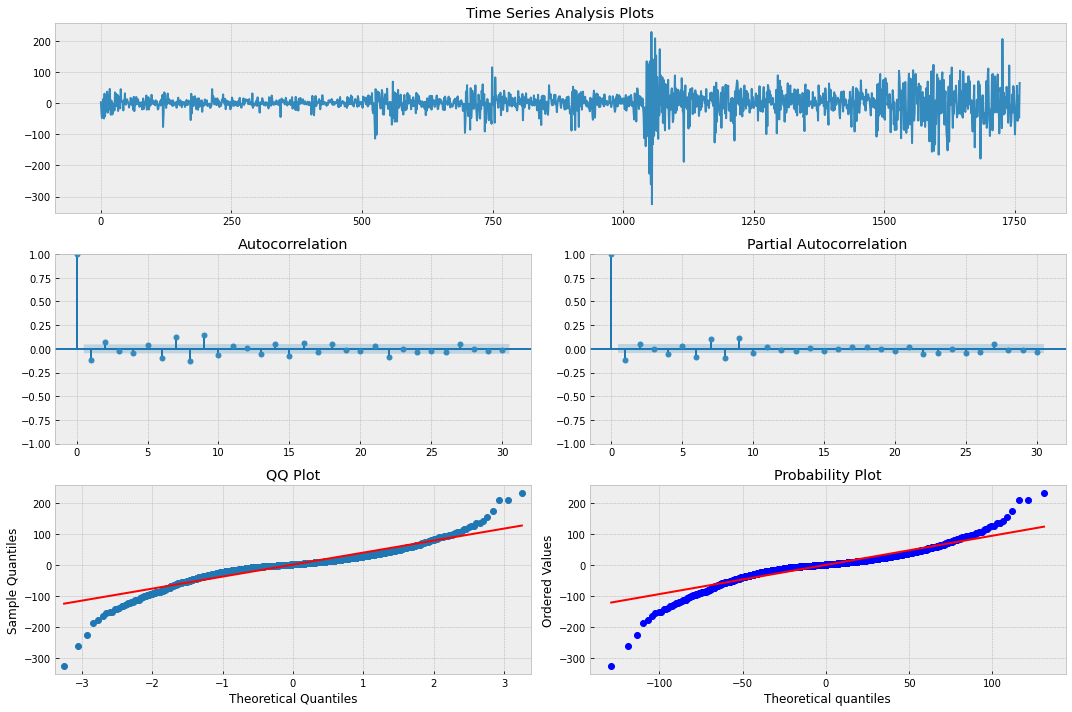

In [110]:
# First difference of SPX prices
_ = tsplot(np.diff(df), lags=30)

It's quite similar to white noise, isn't it? However, there appears to be some significant serial correlation in the ACF, and PACF plots. Also notice the shape of the QQ and Probability plots. This indicates that the process is close to normality but with 'heavy tails'. This means that there should be better models to explain the price of S&P 500.

## Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. The basic equation is:

$$x_{t} = a_0+a_1 t + b$$

The value of the time series is determined by the coefficients, $a_0, a_1$ and time. An example could be a company's sales that increase by the same amount at each time step. For a hypthtical example, consider a company who's stock price was a 100$ to start, and increase by 50c at every time step.

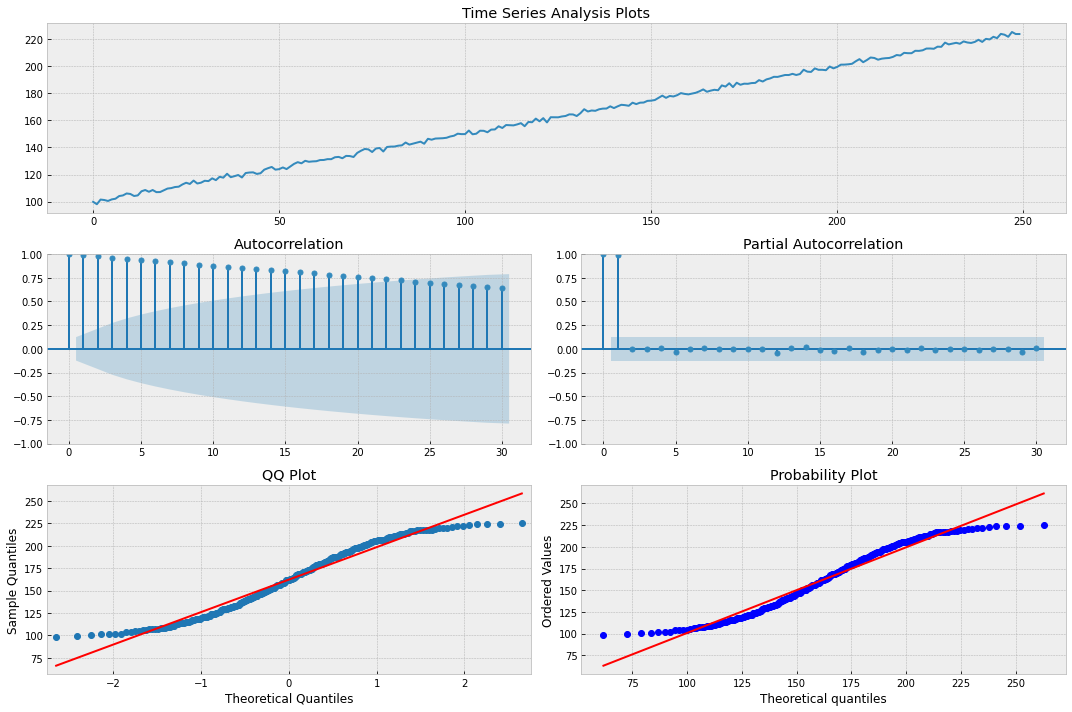

In [111]:
# simulate linear trend

w = np.random.randn(250)
x = np.empty_like(w)

a0 = 100.
a1 = 0.5
for t in range(len(w)):
    x[t] = a0 + a1*t + w[t]
    
_ = tsplot(x, lags=30)

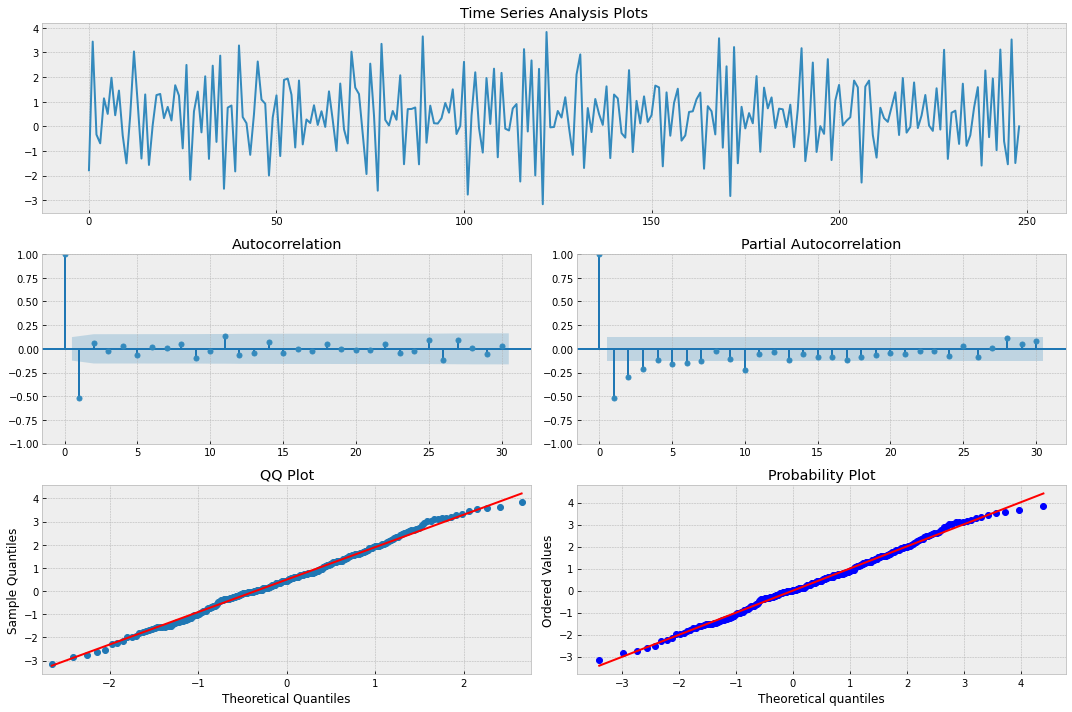

In [113]:
# First difference of simulated prices
_ = tsplot(np.diff(x), lags=30)


Here we can see that the residuals of the model are correlated. Though the distribution is approximately normal, before using this model to make predictions we would have to account for and remove the obvious autocorrelation (the significant value at lag 1) present in the series. The significance of the PACF at lag 1 indicates that an autoregressive model may be appropriate.

## Forecasting with Autoregression Model

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems. An autoregression model makes an assumption that the observations at current and previous time steps are useful to predict the value at the next time step. 

An autoregression model is a linear regression model that uses lagged variables as input variables. The Statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class.

### Autoregressive Models of order p $AR(p)$

The autoregressive model is simply an extension of the random walk. It is essentially a regression model which depends linearly on the previous terms: 

$$x_t = \alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t = \sum_{i=1}^{p} t_i\alpha_ix_{t-i}+w_t$$

This is an AR model of order "p",where $p$ represents the number of previous (or lagged) terms used within the model, $\alpha_i$ is the coefficient, and $w_t$ is a white noise term. Note that an AR(1) model with $\alpha_1$ set equal to 1 is a random walk!

One of the most important aspects of the AR(p) model is that it is not always stationary. The stationarity of a particular model depends upon the parameters. For example, an AR(1) model with $\alpha_1$ = 1 is a random walk and therefore not stationary.

In [114]:
# split dataset
X = Re.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

<AxesSubplot:xlabel='Date'>

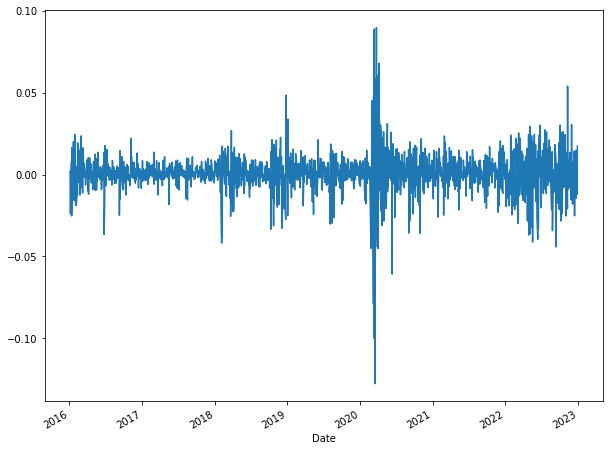

In [115]:
Re.plot(figsize=(10, 8))

In [126]:
max_lag = 30

# Fit the model using AutoReg
model = AutoReg(train, lags=max_lag, trend='n').fit()

# Using the summary, you can visually check the AIC
print(model.summary())

# If you want to programmatically get the AIC value
aic_value = model.aic
print("AIC Value:", aic_value)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1160
Model:                    AutoReg(30)   Log Likelihood                3492.150
Method:               Conditional MLE   S.D. of innovations              0.011
Date:                Tue, 12 Sep 2023   AIC                          -6922.301
Time:                        02:05:57   BIC                          -6766.371
Sample:                            30   HQIC                         -6863.389
                                 1160                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1          -0.1575      0.030     -5.293      0.000      -0.216      -0.099
y.L2           0.0933      0.030      3.102      0.002       0.034       0.152
y.L3           0.0715      0.030      2.371      0.0

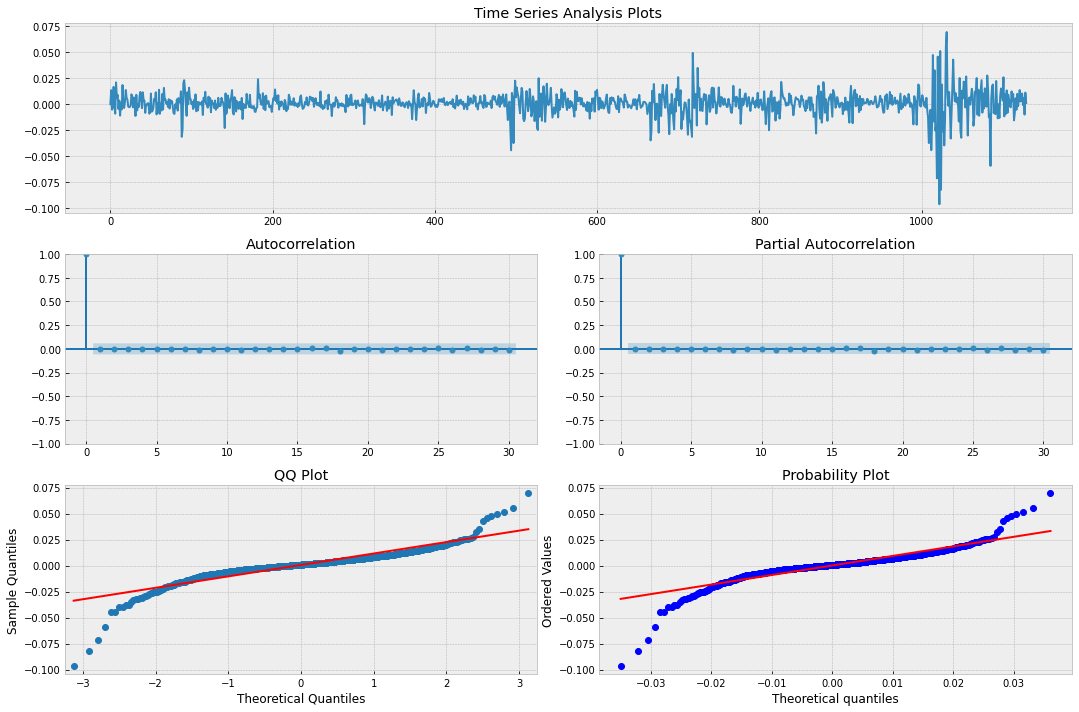

In [123]:
_ = tsplot(model.resid, lags=max_lag)

In [124]:
max_lag = 30
best_aic = np.inf
best_order = 0
best_model = None

# Iterate over multiple lag values
for lag in range(1, max_lag + 1):
    model = AutoReg(train, lags=lag, trend='n').fit()
    if model.aic < best_aic:
        best_aic = model.aic
        best_order = lag
        best_model = model

# Display results
print('Best AR Model Order:', best_order)
print('Best AIC Value:', best_aic)
print(best_model.summary())

Best AR Model Order: 9
Best AIC Value: -7055.463318095056
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1160
Model:                     AutoReg(9)   Log Likelihood                3537.732
Method:               Conditional MLE   S.D. of innovations              0.011
Date:                Tue, 12 Sep 2023   AIC                          -7055.463
Time:                        02:05:00   BIC                          -7004.979
Sample:                             9   HQIC                         -7036.407
                                 1160                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1          -0.1538      0.029     -5.253      0.000      -0.211      -0.096
y.L2           0.0917      0.029      3.110      0.002       0.034       

In [130]:
# Create a 21 day forecast of SPX returns with 95%, 99% CI
n_steps = 21

# Forecast
f = best_model.forecast(steps=n_steps)

# Standard error (assuming normality of residuals)
std_err = best_model.resid.std()

# Confidence intervals for 95% CI
z_95 = 1.96  # For 95% confidence
lower_ci_95 = f - z_95 * std_err
upper_ci_95 = f + z_95 * std_err

# Confidence intervals for 99% CI
z_99 = 2.576  # For 99% confidence
lower_ci_99 = f - z_99 * std_err
upper_ci_99 = f + z_99 * std_err

idx = pd.date_range(df.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame({'forecast': f, 'lower_ci_95': lower_ci_95, 'upper_ci_95': upper_ci_95}, index=idx)
fc_99 = pd.DataFrame({'lower_ci_99': lower_ci_99, 'upper_ci_99': upper_ci_99}, index=idx)

fc_all = fc_95.join(fc_99)
fc_all.head()

forecast  lower_ci_95  upper_ci_95  lower_ci_99  upper_ci_99
2022-12-29      0.00        -0.02         0.02        -0.03         0.03
2022-12-30      0.00        -0.02         0.02        -0.03         0.03
2022-12-31     -0.00        -0.02         0.02        -0.03         0.03
2023-01-01      0.00        -0.02         0.02        -0.03         0.03
2023-01-02     -0.00        -0.03         0.02        -0.03         0.03

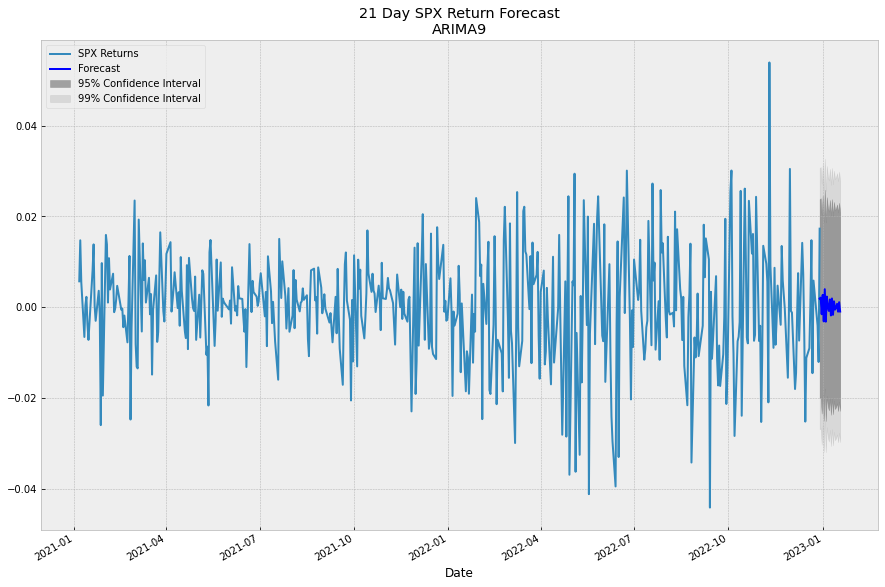

In [132]:
import matplotlib.pyplot as plt

# Set the style
plt.style.use('bmh')

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the last 500 observations of SPX Returns
Re.iloc[-500:].plot(ax=ax, label='SPX Returns')

# Plot the forecast with 95% and 99% confidence intervals
fc_all['forecast'].plot(ax=ax, style='b-', label='Forecast')
ax.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='gray', alpha=0.7, label='95% Confidence Interval')
ax.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='gray', alpha=0.2, label='99% Confidence Interval')

# Set title and labels
ax.set_title('{} Day SPX Return Forecast\nARIMA{}'.format(n_steps, best_order))
ax.legend(loc='best', fontsize=10)

plt.show()

In [135]:
# make predictions
predictions = best_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [136]:
test_period = 7
for i in range(test_period):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test[:test_period], predictions[:test_period]))

predicted=0.001870, expected=-0.000172
predicted=0.002097, expected=0.002706
predicted=-0.001558, expected=0.002301
predicted=0.002705, expected=-0.004414
predicted=-0.003143, expected=0.003154
predicted=0.003958, expected=0.003435
predicted=-0.003205, expected=0.009994


In [137]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.006


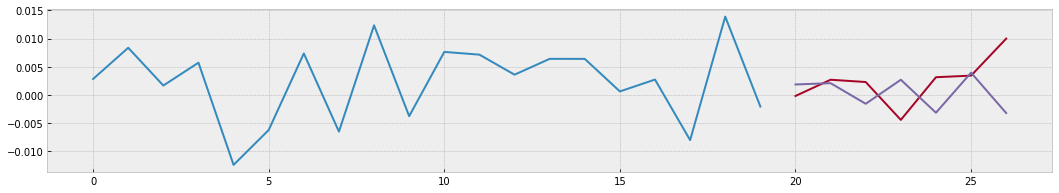

In [138]:
# plot predictions and expected results on the test data
plt.plot(train_y[-20:])
plt.plot([None for i in train_y[-20:]] + [x for x in test_y[:test_period]])
plt.plot([None for i in train_y[-20:]] + [x for x in predictions[:test_period]])

Obviously, we want to rebuild the model after each day as the new data becomes available.

## Walk Forward Validation

The Statsmodels API does not make it easy to update the model as new observations become available. One way would be to re-train the AR model each day as new observations become available, and that may be a valid approach, if not computationally expensive. An alternative would be to use the learned coeficients and manually make predictions. This requires that the history of prior observations be kept and that the coeficients be retrieved from the model and used in the regression equation to come up with new forecasts.

In [139]:
# split dataset
X = Re.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

In [151]:
# Determine optimal lag based on BIC
best_bic = np.inf
best_lag = None

for lag in range(1, 51):  # assuming a maximum of 50 lags to check
    model = AutoReg(train, lags=lag)
    result = model.fit()
    if result.bic < best_bic:
        best_bic = result.bic
        best_lag = lag

# Fit model using the best lag value
model = AutoReg(train, lags=best_lag)
model_fit = model.fit()

window = len(model_fit.model._lags) # Get the lags used in the model
coef = model_fit.params

In [152]:
# walk forward over time steps in test
history = list(train[-window:])  # last "window" values from the train set

predictions = []

for t in test:
    lag = history[-window:]  # last "window" observations
    yhat = coef[0]  # intercept
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    predictions.append(yhat)
    history.append(t)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE: ', rmse)

RMSE:  0.012456845565257633


In [153]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.012


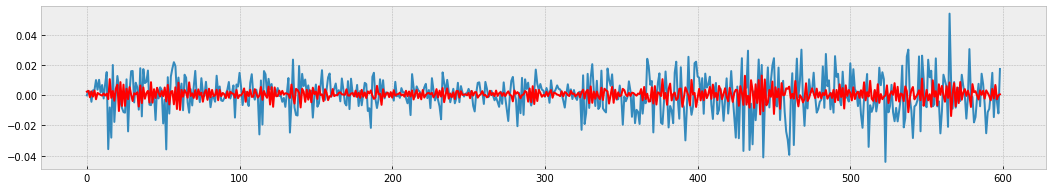

In [154]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')

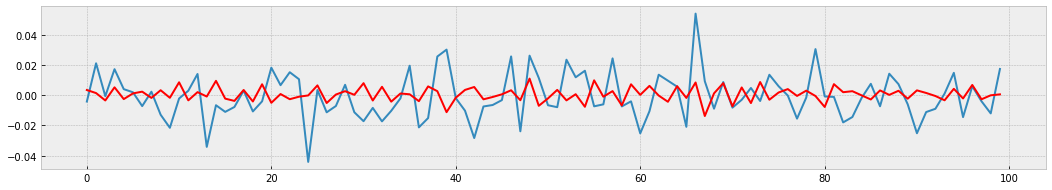

In [155]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

## Moving Average Models for Forecasting

The difference between what was expected and what was predicted is called the residual error. The residual errors from forecasts on a time series provide another source of information that we can model. Residual errors themselves form a time series that can have temporal structure. A simple autoregression model of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts. This type of model is called a moving average model, the same name but very different from moving average smoothing.


**Autoregression of Residual Error**
We can model the residual error time series using an autoregression model. This is a linear regression model that creates a weighted linear sum of lagged residual error terms.
We can use the autoregression model (AR) provided by the Statsmodels library. Building on the persistence model (see the previous section), we can first train the model on the residual errors calculated on the training dataset.

- The motivation for the MA model is that we can explain "shocks" in the error process directly by fitting a model to the error terms. (In an AR(p) model these shocks are observed indirectly by using past observations)
 
$$x_t=w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$

Where $w_t$ is white noise with $E(w_t)=0$ and variance $\sigma^2$

By definition, ACF $ρ_k$ should be zero for k>q.


In [156]:
# create lagged dataset
values = pd.DataFrame(Re.values)
Re3 = pd.concat([values.shift(1), values], axis=1)
Re3.columns = ['t', 't+1']
Re3 = Re3[1:]
Re3.head()

t   t+1
1  0.00 -0.01
2 -0.01 -0.02
3 -0.02 -0.01
4 -0.01  0.00
5  0.00  0.01

In [157]:
# split into train and test sets
X = Re3.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [158]:
# persistence model on training set
train_pred = [x for x in train_X]

In [159]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [163]:
# Model the training set residuals
model = AutoReg(train_resid, lags=1)  # You can adjust the number of lags or use methods like BIC/AIC to select the best lag
model_fit = model.fit()
window = len(model_fit.model._lags)  # Get the number of lags used in the model
coef = model_fit.params

In [164]:
print('Lag=%d, Coef=%s' % (window, coef))

Lag=1, Coef=[ 3.45975334e-05 -6.68866643e-01]


The autoregression model requires the residual error of the 17 previous time steps. Therefore, we must keep these values handy. As we step through the test dataset timestep by timestep making predictions and estimating error, we can then calculate the actual residual error and update the residual error time series lag values (history) so that we can calculate the error at the next time step.

In [165]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions, expected_error = [], []

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)

    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]

    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    #print('predicted error=%f, expected error=%f' % (pred_error, error))

This is a walk forward forecast, or a rolling forecast, model. We end up with a time series of the residual forecast error from the train dataset and a predicted residual error on the test dataset. We can plot these and get a quick idea of how skillful the model is at predicting residual error.

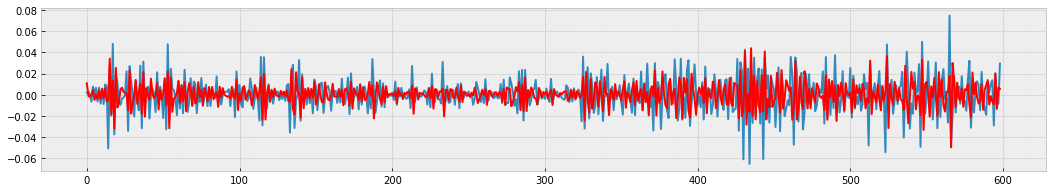

In [166]:
# plot predicted error
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show()

### ARIMA Model for Forecasting

The Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis. An ARIMA model is a class of statistical model for analyzing and forecasting time series data.

ARIMA is an acronym that stands for Autoregressive Integrated Moving Average Model. This acronym is descriptive, capturing the key aspects of the model itself:

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

Let's start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors. First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.





Hence, an ARMA model attempts to capture both of these aspects when modelling financial time series. Note that an ARMA model does not take into account volatility clustering, a key empirical phenomena of many financial time series which we will discuss later.

$$x_t=\alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$

Where $w_t$ is white noise with $E(w_t)=0$ and variance $\sigma^2$
An ARMA model will often require fewer parameters than an AR(p) or MA(q) model alone. That is, it is redundant in its parameters

In [169]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the model
model = ARIMA(Re, order=(5,1,0))
model_fit = model.fit()

In [170]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1760
Model:                 ARIMA(5, 1, 0)   Log Likelihood                5138.319
Date:                Tue, 12 Sep 2023   AIC                         -10264.637
Time:                        02:28:54   BIC                         -10231.802
Sample:                             0   HQIC                        -10252.503
                               - 1760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9696      0.011    -85.159      0.000      -0.992      -0.947
ar.L2         -0.6622      0.017    -38.478      0.000      -0.696      -0.629
ar.L3         -0.4628      0.020    -22.697      0.0

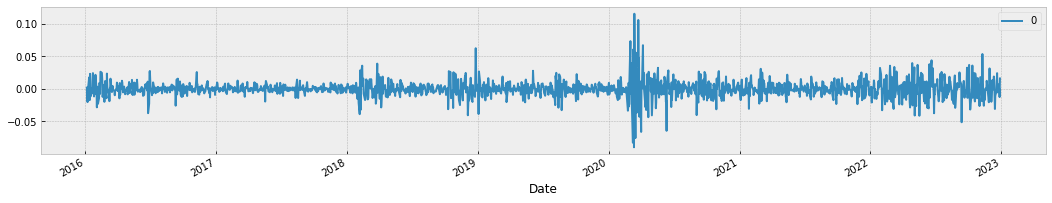

In [171]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

<AxesSubplot:ylabel='Density'>

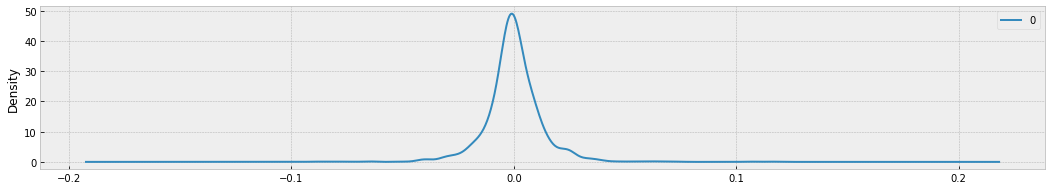

In [172]:
# density plot of residuals
residuals.plot(kind='kde')

In [178]:
# summary stats of residuals
residuals.describe()

0
count 1760.00
mean     0.00
std      0.01
min     -0.09
25%     -0.01
50%     -0.00
75%      0.01
max      0.12

## Rolling Forecast ARIMA Model

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

In [188]:
# split into train and test sets
X = Re.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [190]:
from tqdm import tqdm

# walk-forward validation
total_tests = len(test)

# Using tqdm to wrap the range in order to show a progress bar
for t in tqdm(range(total_tests), desc="Processing", ncols=100):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

Processing: 100%|█████████████████████████████████████████████████| 599/599 [04:09<00:00,  2.40it/s]


In [192]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.014


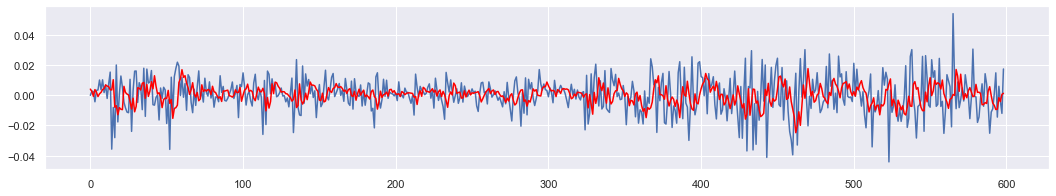

In [193]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red')

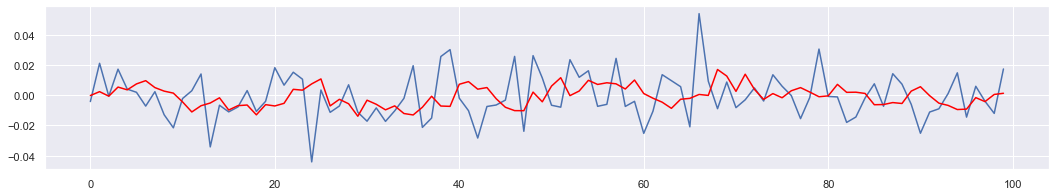

In [194]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

## Grid Search ARIMA Model Hyperparameters

In [204]:
from tqdm import tqdm

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    
    # wrap range with tqdm for progress bar
    for t in tqdm(range(len(test)), desc="Forecasting"):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit() 
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate parameters
p = 3
d = 1
q = 0
order = (p, d, q)
evaluate_arima_model(Re.values, order)

Forecasting: 100%|███████████████████████████████████████████████████████████████████| 599/599 [01:55<00:00,  5.19it/s]


0.01413031589809419

In [207]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]

evaluate_models(Re.values, p_values, d_values, q_values)

## ARCH and GARCH models

In this section, we will discuss conditional heteroskedasticity, leading us to our first conditional heteroskedastic model, known as ARCH. Then we will discuss extensions to ARCH, leading us to the famous Generalised Autoregressive Conditional Heteroskedasticity model of order p,q, also known as GARCH(p,q). GARCH is used extensively within the financial industry as many asset prices are conditional heteroskedastic.

### Conditional Heteroskedasticity

The main motivation for studying conditional heteroskedasticity in finance is that of volatility of asset returns. A collection of random variables is heteroskedastic if there are certain groups, or subsets, of variables within the larger set that have a different variance from the remaining variables.

In finance, an increase in variance maybe correlated to a further increase in variance. For instance, on a day that equities markets undergo a substantial drop, automated risk management sell orders in long only portfolios get triggered, which lead to further fall in the price of equities within these portfolios, leading to significant downward volatility.

These "sell-off" periods, as well as many other forms of volatility, lead to heteroskedasticity that is serially correlated and hence conditional on periods of increased variance. Thus we say that such series are conditional heteroskedastic.

One of the challenging aspects of conditional heteroskedastic series is ACF plots of a series with volatility might still appear to be a realisation of stationary discrete white noise. This is despite the fact that the series is most definitely non-stationary as its variance is not constant in time.
To incorporate CH in our model, we can create a model that utilises an autoregressive process for the variance itself - a model that actually accounts for the changes in the variance over time using past values of the variance.
This is the basis of the Autoregressive Conditional Heteroskedastic (ARCH) model.
Autoregressive Conditionally Heteroskedastic Models - ARCH(p)

ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series.
$$Var(\epsilon_t) = \alpha_0 + \alpha_1Var(\epsilon_{t-1})+…+\alpha_pVar(\epsilon_{t-p})+w_t$$
The actual time series is given by:
$$\epsilon_t = w_t\sqrt{\alpha_0 + \alpha_1\epsilon_{t-1}^2+…+\alpha_p\epsilon_{t-p}^2}$$
For ARCH(1), this reads: $$\epsilon_t = w_t\sqrt{\alpha_0+\alpha_1\epsilon_{t-1}^2}$$

When To Apply ARCH(p)?

When we were attempting to fit an AR(p) model and are concerned with the decay of the $p$ lag on a ACF plot of the series, we can apply the same logic to the square of the residuals. If we find that we can apply an AR(p) to these square residuals then we have an indication that an ARCH(p) process may be appropriate.
Note that ARCH(p) should only ever be applied to a series that has already had an appropriate model fitted sufficient to leave the residuals looking like discrete white noise. Since we can only tell whether ARCH is appropriate or not by squaring the residuals and examining the ACF, we also need to ensure that the mean of the residuals is zero.
ARCH should only ever be applied to series that do not have any trends or seasonal effects, i.e. that has no (evident) serially correlation. ARIMA is often applied to such a series, at which point ARCH may be a good fit.

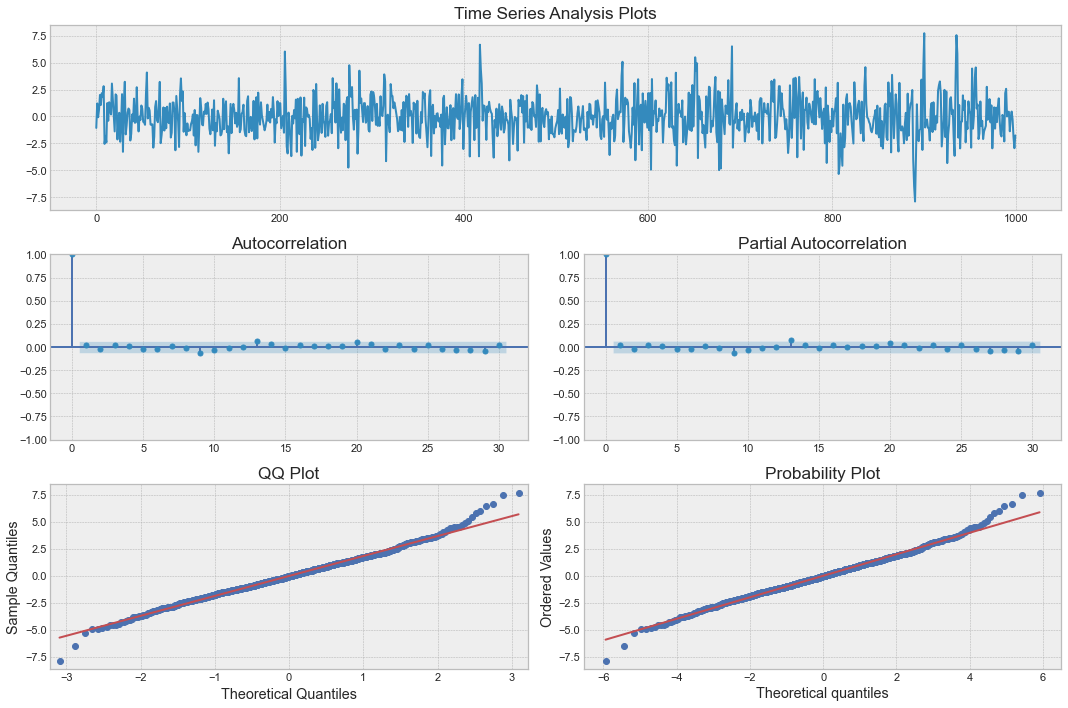

In [209]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(y, lags=30)

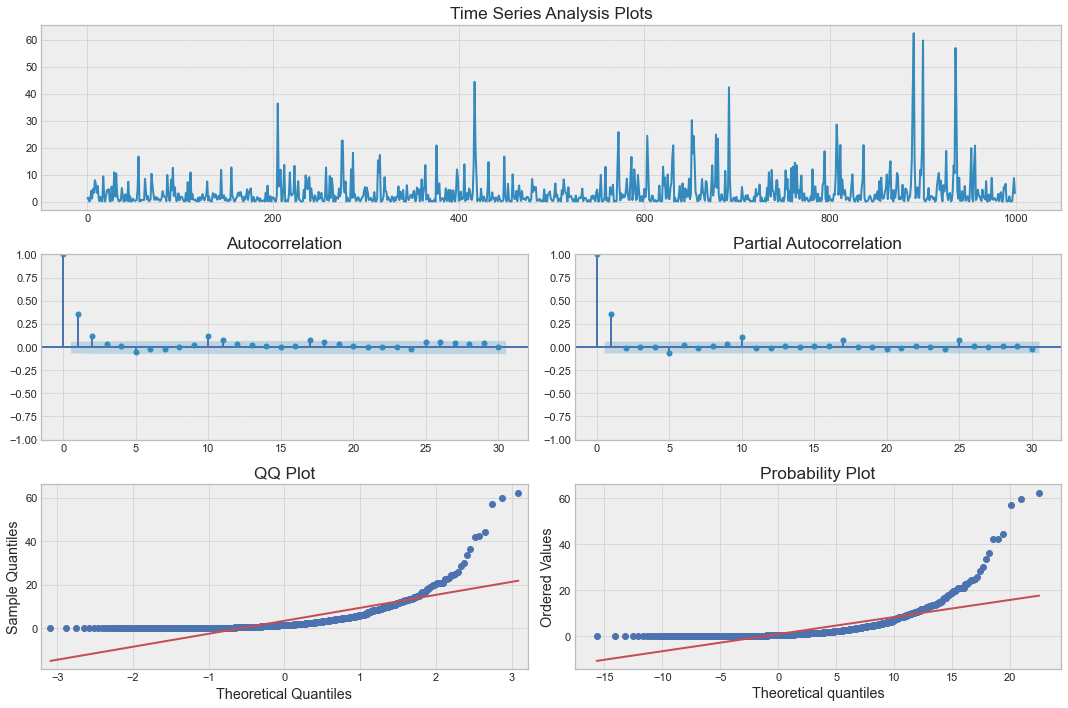

In [210]:
tsplot(y**2, lags=30)

Notice the time series looks just like white noise. However, when we plot the square of the series, the ACF, and PACF seem to show significance at lag 1 indicating an AR(1) model for the variance may be appropriate.
An obvious question to ask at this stage is if we are going to apply an AR(p) process to the variance, why not a Moving Average MA(q) model as well? Or a mixed model such as ARMA(p,q)?
This is actually the motivation for the Generalised ARCH model, known as GARCH
Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)
GARCH(p, q) is an ARMA model applied to the variance of a time series i.e., it has an autoregressive term and a moving average term. The AR(p) models the variance of the residuals (squared errors) or simply our time series squared. The MA(q) portion models the variance of the process.

$$\epsilon_t = \sigma_t w_t$$

Where $w_t$ is discrete white noise, with zero mean and unit variance, and $\sigma^2$ is given by:

$$\sigma_t^2=\alpha_0+\sum_{i=1}^{p}\alpha_i\epsilon_{t-i}^2+\sum_{j=1}^{q}\beta_j\sigma_{t-j}^2$$

Where $\alpha_i$ and $\beta_j$ are parameters of the model.For GARCH(1,1), $\sigma^2$ is:

$$\sigma_t^2=\alpha_0+\alpha_1\epsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$

$\alpha_1 + \beta_1$ must be less than 1 or the model is unstable. We can simulate a GARCH(1, 1) process below.

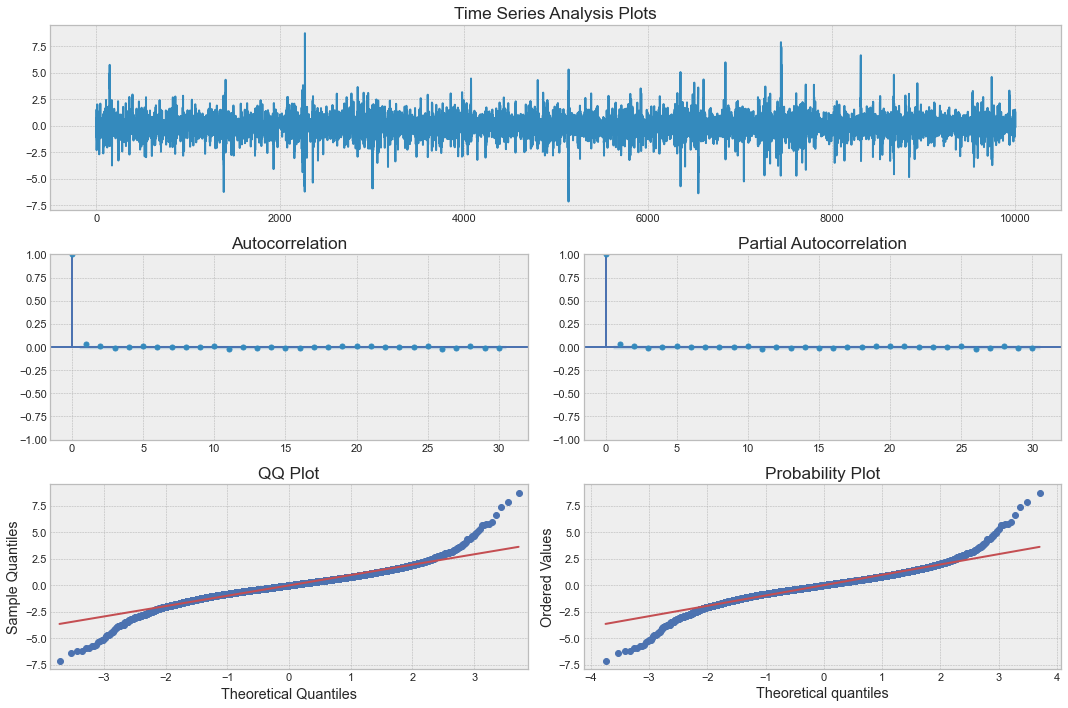

In [211]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

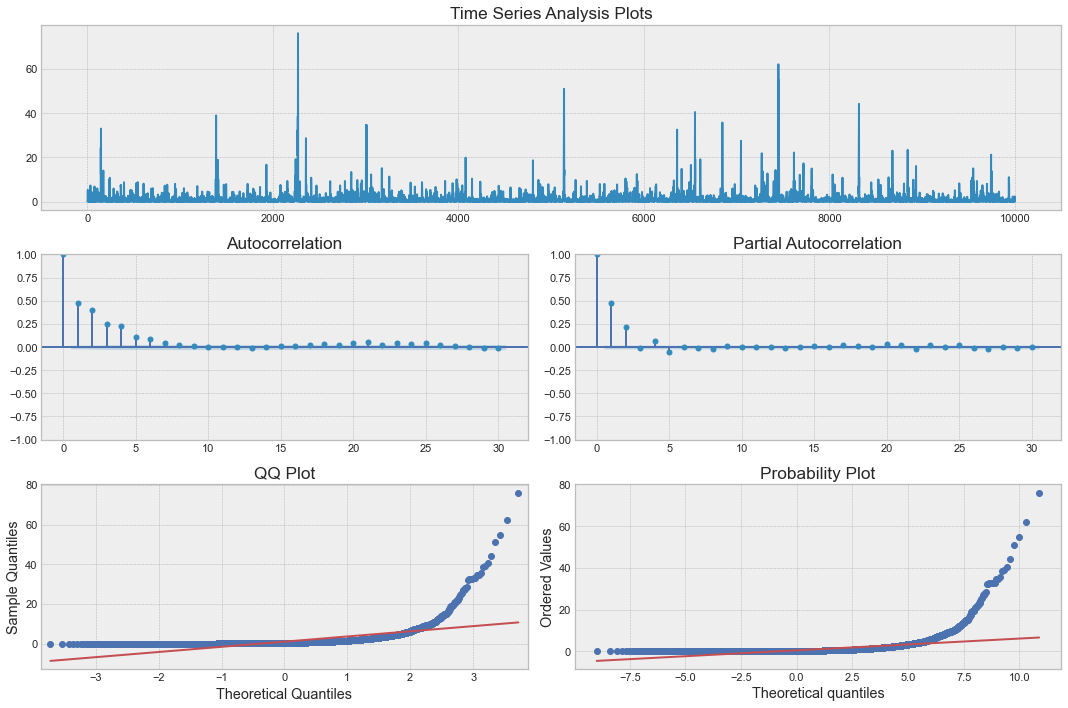

In [212]:
_ = tsplot(eps**2, lags=30)

In [214]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

#! pip install arch
from arch import arch_model

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.790134449831
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.312781716888
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267318712
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Tue, Sep 12 2023   Df Residuals:                     9999
Time:       

### Application to Financial Time Series

Now apply the procedure to a financial time series. Here we're going to use SPX returns. The process is as follows:
Iterate through combinations of ARIMA(p, d, q) models to best fit our time series.
Pick the GARCH model orders according to the ARIMA model with lowest AIC.
Fit the GARCH(p, q) model to our time series.
Examine the model residuals and squared residuals for autocorrelation
Here, we first try to fit SPX return to an ARIMA process and find the best order.

In [215]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = Re
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)
res_tup = _get_best_model(TS)

aic:    inf | order: None


In [59]:
order = res_tup[1]
model = res_tup[2]

Since we've already taken the log of returns, we should expect our integrated component d to equal zero, which it does. We find the best model is ARIMA(4,0,3). Now we plot the residuals to decide if they possess evidence of conditional heteroskedastic behaviour

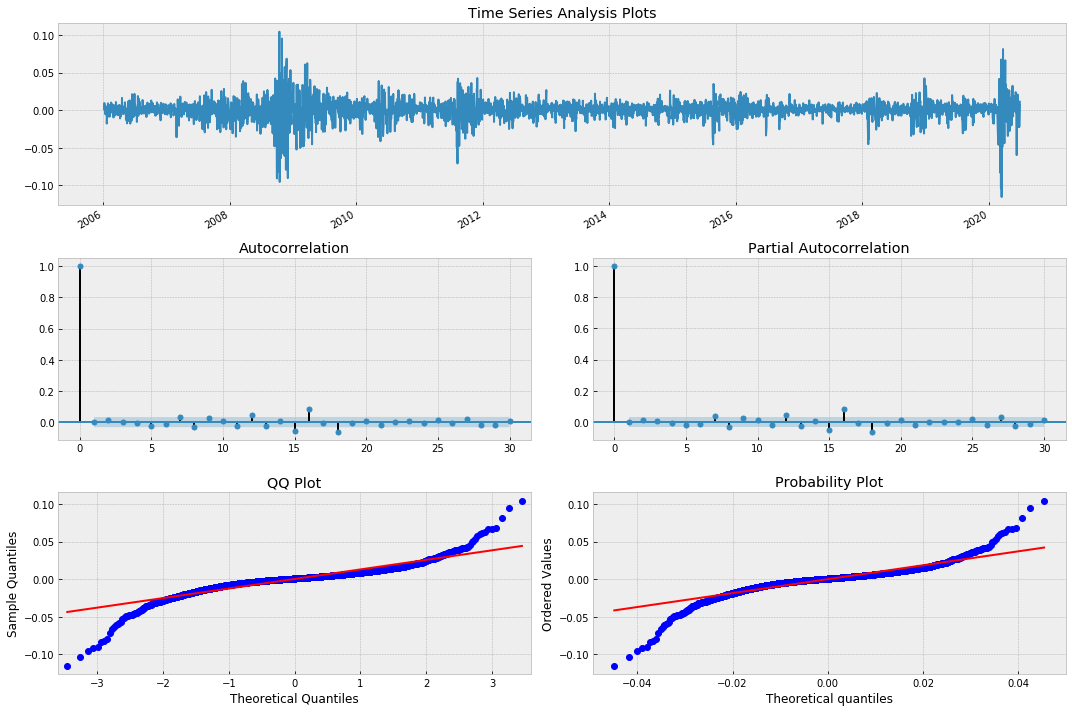

In [60]:
tsplot(model.resid, lags=30)

We find the reiduals look like white noise. Let's look at the square of residuals

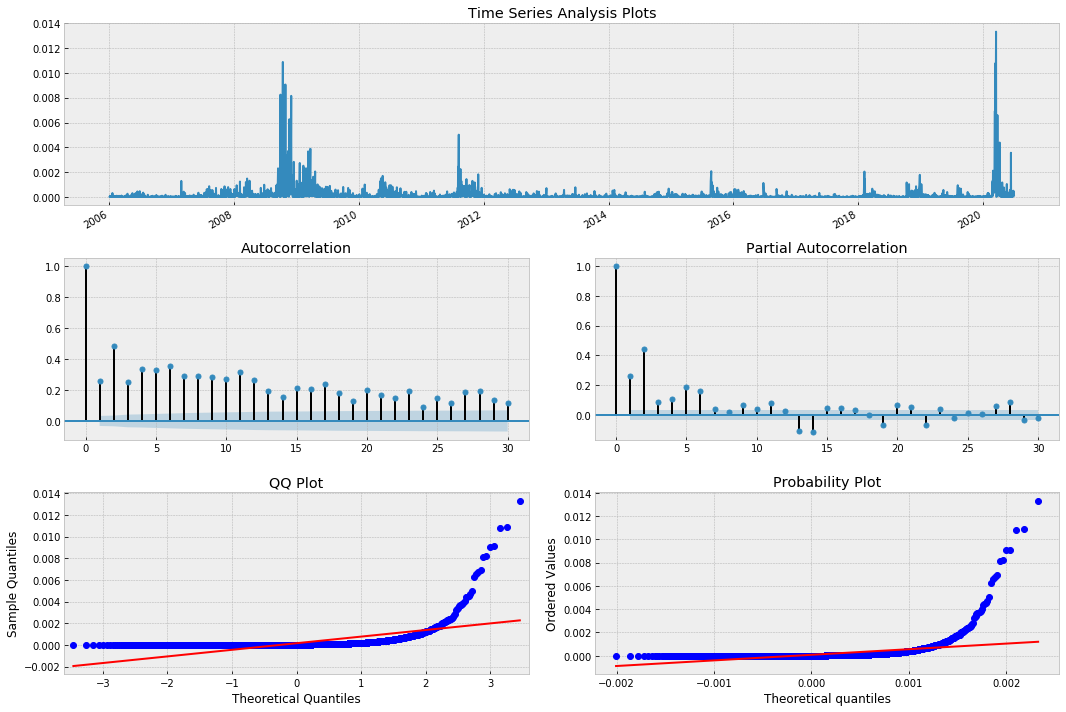

In [61]:
tsplot(model.resid**2, lags=30)

We can see clear evidence of autocorrelation in squared residuals. Let's fit a GARCH model and see how it does.

In [78]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = order[0]
o_ = order[1]
q_ = order[1]

# Using student T distribution usually provides better fit
am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.171
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.171
Vol Model:                             ARCH   Log-Likelihood:                9907.53
Distribution:      Standardized Student's t   AIC:                          -19801.1
Method:                  Maximum Likelihood   BIC:                          -19757.6
                                              No. Observations:                 3646
Date:                      Mon, Jan 25 2021   Df Residuals:                     3639
Time:                              07:48:28   Df Model:                            7
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


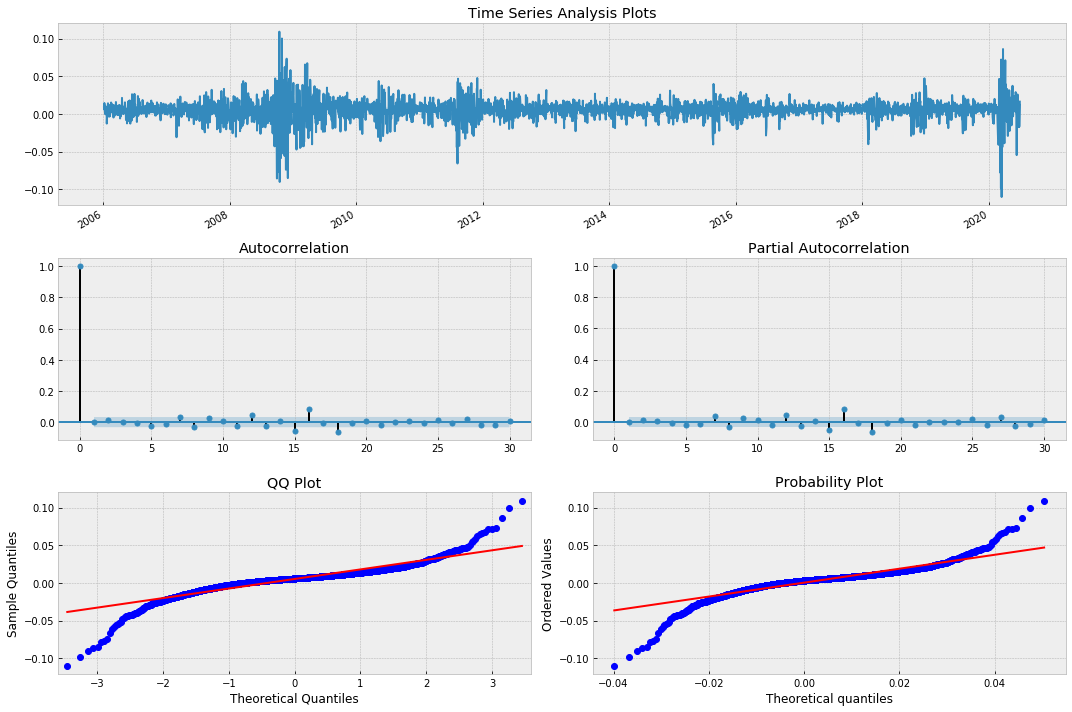

In [79]:
tsplot(res.resid, lags=30)

The plots looks like a realisation of a discrete white noise process, indicating a good fit. Let's plot a square of residuals to be sure

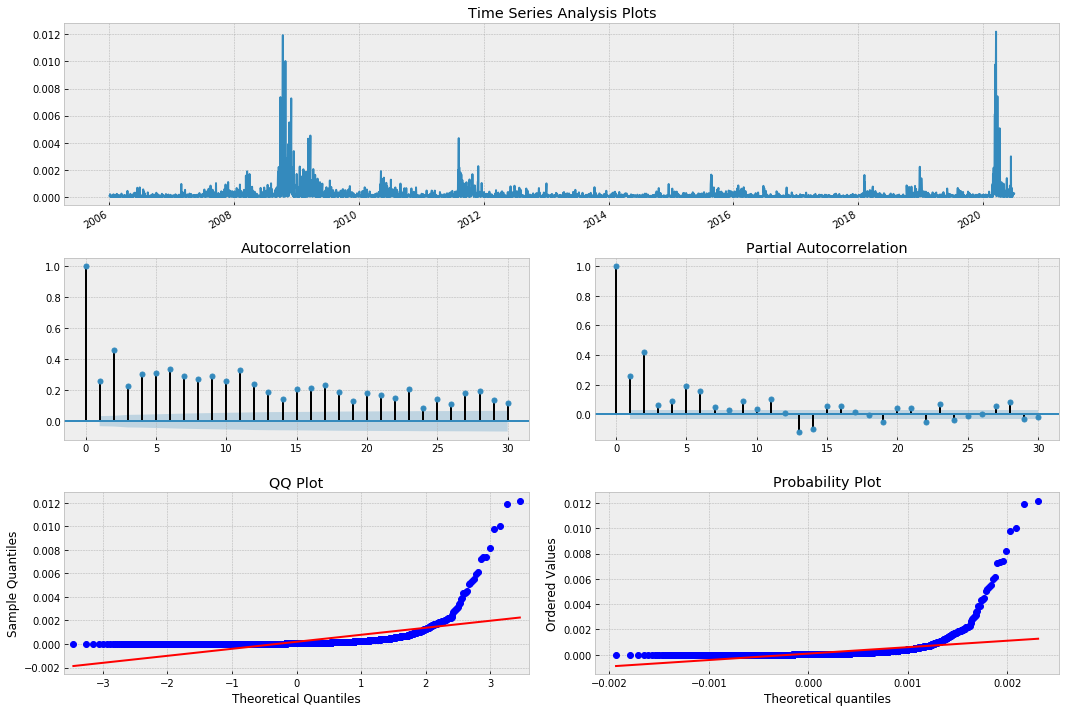

In [80]:
tsplot(res.resid**2, lags=30)

## ARIMA+GARCH Trading Strategy on the S&P500 Index

## Strategy Overview

The idea of this strategy is as below:

- For each day, $n$, use differenced logarithmic returns of S&P 500 for the previous $k$ days to fit an optimal ARIMA and GARCH model

- Use the combined model to make a prediction for the next day returns

- If the prediction is positive, go long the stock and if negative, short the stock at $n_{th}$ day's close

- If the prediction is the same as the previous day then do nothing

we will work with $k=500$, but this is parameter that can be optimised in order to improve performance or reduce drawdown.

**Note: The backtest is doesnot take comission or slippage into account, hence the performance achieved in a real trading system would be lower than what you see here.**

 ### Strategy Implementation

In [81]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [82]:
# load dataset
start = datetime.datetime(2006,1,1)
end = datetime.datetime(2020,6,30)
df = yf.download("^GSPC", start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [85]:
# display first few lines of a time series
df.head()

Date
2006-01-03   1268.80
2006-01-04   1273.46
2006-01-05   1273.48
2006-01-06   1285.45
2006-01-09   1290.15
Name: Adj Close, dtype: float64

In [88]:
# log returns
lrets = np.log(df/df.shift(1)).fillna(0)
lrets.index = pd.DatetimeIndex(lrets.index.values,freq=lrets.index.inferred_freq)

In [89]:
lrets.head()

2006-01-03   0.00
2006-01-04   0.00
2006-01-05   0.00
2006-01-06   0.01
2006-01-09   0.00
Name: Adj Close, dtype: float64

In [90]:
windowLength = 252
foreLength = len(lrets) - windowLength

In [91]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1,4) # [1,2,3]
    for i in pq_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,0,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, 0, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: %6.5f | order: %s'%(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

At this stage we need to loop through every day in the trading data and fit an appropriate ARIMA and GARCH model to the rolling window of length $k=500$. Given that we try 32 separate ARIMA fits and fit a GARCH model, for each day, the indicator can take a long time to generate.

In [92]:
signal = 0*lrets[-foreLength:]
for d in range(foreLength):
    # create a rolling window by selecting the values between 1+d and k+d of S&P500 returns
    TS = lrets[(1+d):(windowLength+d)] 
    # Find the best ARIMA fit (we set differencing to 0 since we've already differenced the series once)
    res_tup = _get_best_model(TS)
    order = res_tup[1]
    model = res_tup[2]
    #now that we have our ARIMA fit, we feed this to GARCH model
    p_ = order[0]
    o_ = order[1]
    q_ = order[2]

    am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    out = res.forecast(horizon=1, start=None, align='origin')
    signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])

aic: -1836.41566 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1837.11707 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1836.10195 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1838.13416 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1838.59250 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1838.48652 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1837.89074 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1838.51954 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1838.71063 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1838.92961 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1839.78027 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1841.19125 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1849.96732 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1849.59992 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1848.20747 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1844.57444 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1845.27141 | order: (2, 0, 1)
aic: -1846.24160 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1845.39243 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1845.20533 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1844.15231 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1847.75229 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1847.39979 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1847.58076 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1849.69296 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1853.53364 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1850.97615 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1851.29693 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1850.48574 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1852.88766 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1852.96165 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1854.13149 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1853.88889 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1854.81465 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1857.18859 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1857.18582 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1857.11641 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.38651 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.93370 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1827.48707 | order: (2, 0, 2)
aic: -1824.96446 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1824.23376 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1822.05795 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1821.68723 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1817.75966 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1818.10656 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1820.12043 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1813.76388 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.65072 | order: (2, 0, 2)
aic: -1816.54114 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1816.53754 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1813.60244 | order: (2, 0, 2)
aic: -1813.60611 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1804.60556 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.70983 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.65771 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.39630 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1804.70266 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1803.04077 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1803.45346 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1803.59255 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1803.58565 | order: (2, 0, 2)
aic: -1801.61865 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.12748 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.61818 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.73911 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1806.39717 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.91338 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1806.74590 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1806.68773 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1804.19888 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1804.48183 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.68023 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.97874 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1807.97044 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1807.88175 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1807.86837 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.80885 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.64597 | order: (2, 0, 2)
aic: -1805.93285 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1804.63451 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.87736 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.98829 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.61941 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.57437 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1807.98121 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1806.36254 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1806.22603 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1793.91004 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1801.88789 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1804.90375 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1804.95695 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.53914 | order: (3, 0, 2)
aic: -1811.50972 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1811.13540 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.25259 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.84915 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.97539 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.40788 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1810.54549 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.28144 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1807.68765 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.26691 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1818.48416 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.85957 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1826.05085 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1824.21949 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.76932 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1806.18573 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1814.55260 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1816.69009 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.54396 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1813.77027 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1821.44800 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1821.20874 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.33379 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1819.78329 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1821.33635 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1816.12353 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1814.95157 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1816.13694 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.23788 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1818.45634 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1823.12476 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1826.07001 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1827.55724 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1829.81200 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1820.74052 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1829.98779 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1826.33217 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1818.81628 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1820.30607 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.21765 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.22144 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.22198 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.93989 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1831.93910 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1827.85722 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1827.22690 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1823.32134 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1822.50388 | order: (3, 0, 3)
aic: -1809.99157 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.04624 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1803.49862 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1801.13877 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1801.32943 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1801.86729 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1784.19118 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1774.78615 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1772.44393 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1769.39703 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.50013 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1752.07766 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.67668 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.12853 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.40518 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.47004 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1735.63182 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1735.74441 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1735.93824 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1733.77375 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1734.08266 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.13712 | order: (2, 0, 2)
aic: -1731.53772 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1723.43007 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1718.28247 | order: (2, 0, 2)
aic: -1717.79335 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1715.94262 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1713.65898 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1709.81685 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1711.63372 | order: (2, 0, 2)
aic: -1707.31878 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1712.41198 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1709.93405 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1706.54066 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1712.92860 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1710.59498 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1705.29504 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1697.82952 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1691.89594 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1694.12514 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1695.75184 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1692.74058 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1693.13133 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1696.53216 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1694.02799 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1694.02904 | order: (3, 0, 3)
aic: -1690.83583 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1690.92793 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1690.85481 | order: (1, 0, 1)
aic: -1699.31547 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1693.00473 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1692.77144 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1690.84782 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1690.89356 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1690.88883 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1691.69399 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1691.07630 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1690.17104 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1690.70567 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1690.62560 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1680.88761 | order: (2, 0, 2)
aic: -1680.82288 | order: (2, 0, 2)
aic: -1680.47368 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1680.52760 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1680.67434 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1678.75085 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1679.47705 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1679.17311 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1677.28571 | order: (2, 0, 2)
aic: -1668.34534 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1668.24749 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1667.92214 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1667.98223 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1658.21405 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1657.83527 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1654.85140 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1653.12740 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1645.15293 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1644.65114 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1642.42278 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1645.14554 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1640.59180 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1638.85277 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1635.98671 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1633.74447 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1634.13464 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1634.94841 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1622.36946 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1620.10497 | order: (1, 0, 1)
aic: -1622.02229 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1619.15545 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1619.53436 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.59555 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1619.02825 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.35363 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.81873 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.55278 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.49452 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1607.73047 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1606.63091 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1603.65404 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1603.19456 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1603.22500 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1603.21467 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1600.12718 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1599.21084 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1599.96930 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1599.01926 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1597.79226 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1598.26499 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1595.06251 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1594.99818 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1591.58144 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1591.66275 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1589.03568 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1588.07284 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1584.57211 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1583.33965 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1582.67422 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1577.65154 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1577.10922 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.73903 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1567.51528 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1566.56096 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1563.58067 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1563.08882 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1561.12849 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1559.25217 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.88459 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1561.62975 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1559.31543 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1555.41606 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1557.70242 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.87536 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.65000 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.49488 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.67182 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.49377 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1546.90226 | order: (3, 0, 2)
aic: -1542.81059 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.87160 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.77322 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.62762 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.93730 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1540.65375 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.16613 | order: (3, 0, 2)
aic: -1540.54441 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1550.46820 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1549.42188 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1550.35633 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.64067 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1544.50946 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.48679 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.32260 | order: (1, 0, 1)
aic: -1541.96898 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1538.92557 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1537.90295 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.49529 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.80389 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.80048 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1527.80102 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1527.62929 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1515.89179 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1515.70299 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1513.13581 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.29430 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.13138 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.02943 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1509.18854 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1508.58004 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1508.44551 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1500.70249 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1501.26299 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1501.18472 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1501.24334 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1501.16786 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1500.88454 | order: (1, 0, 2)
aic: -1500.69831 | order: (1, 0, 2)
aic: -1500.97422 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1498.81584 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1499.09459 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1499.03774 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1493.95704 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1493.83738 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1492.21639 | order: (1, 0, 1)
aic: -1492.24740 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1491.67904 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1492.32569 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1492.00650 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1491.64905 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1492.02524 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1491.99890 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1492.20393 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1490.55158 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1490.36252 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1490.28658 | order: (1, 0, 1)
aic: -1489.97359 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1488.06183 | order: (1, 0, 1)
aic: -1489.09130 | order: (1, 0, 1)
aic: -1489.42511 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1488.81378 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1488.80046 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1489.16712 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1488.34526 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1488.59935 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1488.60682 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1488.05555 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1486.07149 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1486.59204 | order: (1, 0, 1)
aic: -1485.74292 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1485.64799 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1485.88280 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1485.66663 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1485.74113 | order: (1, 0, 1)
aic: -1485.04620 | order: (1, 0, 1)
aic: -1484.96136 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1485.85727 | order: (1, 0, 1)
aic: -1485.09297 | order: (1, 0, 1)
aic: -1480.81196 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1480.67962 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1481.10451 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1480.73854 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1480.95738 | order: (1, 0, 1)
aic: -1480.06720 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1479.62606 | order: (1, 0, 1)
aic: -1479.33319 | order: (1, 0, 1)
aic: -1479.61482 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1479.69073 | order: (1, 0, 1)
aic: -1478.75838 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1478.80746 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1478.91219 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1479.08262 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1473.86221 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1473.41106 | order: (1, 0, 1)
aic: -1474.18612 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1474.16609 | order: (1, 0, 1)
aic: -1472.21656 | order: (1, 0, 1)
aic: -1472.27009 | order: (1, 0, 1)
aic: -1471.87332 | order: (1, 0, 1)
aic: -1471.52157 | order: (1, 0, 1)
aic: -1469.51695 | order: (1, 0, 1)
aic: -1471.79139 | order: (1, 0, 1)
aic: -1471.29648 | order: (1, 0, 1)
aic: -1470.54309 | order: (1, 0, 1)
aic: -1469.63473 | order: (1, 0, 1)
aic: -1466.93517 | order: (3, 0, 2)
aic: -1464.83969 | order: (1, 0, 1)
aic: -1466.84020 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1465.57498 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1466.69756 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1466.46618 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1467.54252 | order: (1, 0, 1)
aic: -1468.83138 | order: (1, 0, 1)
aic: -1467.20128 | order: (1, 0, 1)
aic: -1465.63741 | order: (1, 0, 1)
aic: -1463.49191 | order: (1, 0, 1)
aic: -1463.28530 | order: (1, 0, 1)
aic: -1466.32779 | order: (1, 0, 1)
aic: -1469.25692 | order: (1, 0, 1)
aic: -1465.18870 | order: (1, 0, 1)
aic: -1465.40060 | order: (1, 0, 1)
aic: -1469.78042 | order: (1, 0, 1)
aic: -1466.78573 | order: (1, 0, 1)
aic: -1466.28500 | order: (1, 0, 1)
aic: -1467.94734 | order: (1, 0, 1)
aic: -1468.64422 | order: (1, 0, 1)
aic: -1468.86245 | order: (1, 0, 1)
aic: -1473.03595 | order: (3, 0, 2)
aic: -1471.59834 | order: (3, 0, 2)
aic: -1470.70921 | order: (3, 0, 2)
aic: -1471.69302 | order: (3, 0, 2)
aic: -1471.68670 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1470.97787 | order: (1, 0, 1)
aic: -1470.58509 | order: (3, 0, 2)
aic: -1472.11525 | order: (1, 0, 1)
aic: -1474.81039 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1473.30200 | order: (1, 0, 1)
aic: -1473.42405 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1473.70221 | order: (1, 0, 1)
aic: -1474.53956 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1468.55207 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1470.07529 | order: (1, 0, 1)
aic: -1468.08681 | order: (1, 0, 1)
aic: -1463.50123 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1463.65677 | order: (2, 0, 3)
aic: -1462.68517 | order: (1, 0, 1)
aic: -1462.63186 | order: (1, 0, 1)
aic: -1449.84511 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1454.35232 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1441.45653 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1436.14938 | order: (1, 0, 1)
aic: -1426.14195 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.05560 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1420.27435 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1420.24814 | order: (1, 0, 1)
aic: -1419.07458 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1418.90396 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1382.22604 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1378.51224 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1378.51370 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1371.52480 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1369.26403 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1360.92249 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1341.38976 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1339.52056 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1320.30137 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1320.22027 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1280.73249 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1281.84327 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1265.72590 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1263.06465 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1264.04490 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1254.10022 | order: (1, 0, 3)
aic: -1252.99224 | order: (3, 0, 1)
aic: -1245.71106 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1245.76283 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1242.74464 | order: (3, 0, 1)
aic: -1241.18696 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1218.47232 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1218.59681 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1216.36179 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1216.20404 | order: (2, 0, 1)
aic: -1216.16470 | order: (2, 0, 1)
aic: -1213.12616 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1210.41714 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1204.17029 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1204.33473 | order: (2, 0, 1)
aic: -1204.13064 | order: (2, 0, 1)
aic: -1204.62207 | order: (2, 0, 1)
aic: -1196.55337 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1190.53717 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1187.54621 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1187.81071 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1187.68973 | order: (2, 0, 1)
aic: -1181.58365 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1170.09284 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1167.48925 | order: (2, 0, 1)
aic: -1160.72868 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1171.63775 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1168.77279 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1167.07882 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1144.86505 | order: (2, 0, 1)
aic: -1143.83521 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1156.70402 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1156.58997 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1143.11493 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1140.81282 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1141.67238 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1141.46551 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1139.57347 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1139.80984 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1139.44748 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1134.82949 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1134.76807 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1148.06932 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1148.37338 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1147.70572 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1147.86768 | order: (3, 0, 3)
aic: -1134.75234 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1134.71686 | order: (2, 0, 1)
aic: -1134.77907 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1134.55407 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1134.10190 | order: (2, 0, 1)
aic: -1133.00053 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1133.00426 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1132.97067 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1131.39100 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1131.56234 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1130.76069 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1130.09205 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1131.66815 | order: (2, 0, 1)
aic: -1129.76598 | order: (2, 0, 1)
aic: -1131.59605 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1131.63649 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1136.63824 | order: (3, 0, 3)
aic: -1136.28319 | order: (3, 0, 3)
aic: -1136.20998 | order: (3, 0, 3)
aic: -1136.19102 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1136.38566 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1136.49320 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1134.00859 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1123.64804 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1122.84583 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1132.01371 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1132.89473 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1124.33471 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1130.97234 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1122.88278 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1122.90652 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1126.48931 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1126.50126 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1120.09716 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1126.41527 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1116.23364 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1118.91640 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1115.62485 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1122.24236 | order: (3, 0, 3)
aic: -1121.97803 | order: (3, 0, 2)
aic: -1120.25851 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1121.22355 | order: (3, 0, 2)
aic: -1120.08664 | order: (3, 0, 3)
aic: -1121.22133 | order: (3, 0, 3)
aic: -1117.04754 | order: (3, 0, 2)
aic: -1117.39932 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1116.48547 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1118.68895 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1118.39147 | order: (3, 0, 2)
aic: -1118.56883 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1115.07082 | order: (3, 0, 2)
aic: -1107.43432 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1111.49580 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1109.54389 | order: (3, 0, 3)
aic: -1111.77337 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1113.30400 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1113.39418 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1112.23245 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1113.16484 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1104.54731 | order: (3, 0, 2)
aic: -1103.27814 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1102.21637 | order: (3, 0, 2)
aic: -1093.39095 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1102.23352 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1101.00177 | order: (3, 0, 2)
aic: -1100.91035 | order: (3, 0, 2)
aic: -1100.59970 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1099.30680 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1098.74684 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1098.54076 | order: (3, 0, 2)
aic: -1098.47972 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1098.49734 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1096.24919 | order: (3, 0, 2)
aic: -1096.26709 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1096.25463 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1097.13347 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1096.46984 | order: (3, 0, 2)
aic: -1096.71944 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1094.68855 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1094.71458 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1094.73654 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1094.51769 | order: (2, 0, 3)
aic: -1094.42007 | order: (2, 0, 3)
aic: -1094.45764 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1094.44888 | order: (2, 0, 3)
aic: -1093.93110 | order: (2, 0, 3)
aic: -1094.27333 | order: (2, 0, 3)
aic: -1094.24789 | order: (3, 0, 2)
aic: -1092.72034 | order: (2, 0, 3)
aic: -1092.78739 | order: (2, 0, 3)
aic: -1092.46469 | order: (2, 0, 3)
aic: -1092.15190 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1084.42090 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1090.08770 | order: (2, 0, 3)
aic: -1090.02693 | order: (2, 0, 3)
aic: -1088.19179 | order: (2, 0, 3)
aic: -1088.11175 | order: (2, 0, 3)
aic: -1087.67078 | order: (2, 0, 3)
aic: -1085.39664 | order: (3, 0, 2)
aic: -1085.41621 | order: (3, 0, 2)
aic: -1086.04337 | order: (3, 0, 2)
aic: -1085.88746 | order: (3, 0, 2)
aic: -1084.65797 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1085.12473 | order: (2, 0, 3)
aic: -1084.17159 | order: (2, 0, 3)
aic: -1082.93353 | order: (2, 0, 3)
aic: -1082.83525 | order: (3, 0, 2)
aic: -1080.90316 | order: (3, 0, 2)
aic: -1080.90332 | order: (3, 0, 2)
aic: -1080.31119 | order: (2, 0, 3)
aic: -1081.00332 | order: (3, 0, 2)
aic: -1081.95955 | order: (3, 0, 2)
aic: -1081.98444 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.98453 | order: (3, 0, 2)
aic: -1082.42847 | order: (3, 0, 2)
aic: -1082.54316 | order: (3, 0, 2)
aic: -1082.67635 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.92025 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.64881 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.74233 | order: (3, 0, 2)
aic: -1081.64682 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.96695 | order: (3, 0, 2)
aic: -1080.84217 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.84259 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.86045 | order: (3, 0, 2)
aic: -1080.87764 | order: (3, 0, 2)
aic: -1080.90836 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1079.07837 | order: (2, 0, 3)
aic: -1080.58551 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.15432 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.13064 | order: (2, 0, 3)
aic: -1080.43306 | order: (2, 0, 3)
aic: -1079.82309 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.10804 | order: (2, 0, 3)
aic: -1081.19424 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.58781 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.98761 | order: (2, 0, 3)
aic: -1080.19032 | order: (3, 0, 2)
aic: -1079.11460 | order: (3, 0, 2)
aic: -1079.21875 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1079.05802 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1079.04851 | order: (3, 0, 2)
aic: -1079.03347 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1079.07314 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.29615 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.32469 | order: (2, 0, 3)
aic: -1079.55651 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1078.18420 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.50768 | order: (3, 0, 2)
aic: -1080.76847 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.77828 | order: (3, 0, 2)
aic: -1080.26349 | order: (3, 0, 2)
aic: -1081.04140 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.04576 | order: (3, 0, 2)
aic: -1081.12493 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.47106 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.52595 | order: (3, 0, 2)
aic: -1079.72123 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.57123 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.53227 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.52210 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.87576 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.90073 | order: (3, 0, 2)
aic: -1080.98379 | order: (3, 0, 2)
aic: -1080.63266 | order: (3, 0, 2)
aic: -1080.23352 | order: (3, 0, 2)
aic: -1080.17516 | order: (3, 0, 2)
aic: -1080.17518 | order: (3, 0, 2)
aic: -1080.80229 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1080.79487 | order: (3, 0, 2)
aic: -1080.81578 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.07875 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1079.82235 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1081.35354 | order: (3, 0, 2)
aic: -1081.38488 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1079.29295 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1082.46444 | order: (3, 0, 2)
aic: -1082.83780 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1082.59146 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1082.61684 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1085.99806 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1086.03230 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1086.50557 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1088.20431 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1089.55432 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1093.05370 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1093.40010 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1093.50043 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1093.33246 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1091.84292 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1101.34506 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1106.14680 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1106.27172 | order: (3, 0, 2)
aic: -1106.32856 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1108.58150 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1110.20278 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1117.75647 | order: (2, 0, 1)
aic: -1119.10074 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1125.01615 | order: (2, 0, 1)
aic: -1125.15028 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1144.93722 | order: (3, 0, 2)
aic: -1146.39418 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1157.19700 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1166.12787 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1166.24705 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1169.01938 | order: (3, 0, 2)
aic: -1170.57170 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1180.19146 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1180.18077 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1181.97303 | order: (3, 0, 2)
aic: -1182.14312 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1205.32971 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1204.34747 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1203.26412 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1203.48430 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1204.05649 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1204.65301 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1213.09080 | order: (2, 0, 2)
aic: -1214.44845 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1215.57684 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1216.91747 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1216.92861 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1222.17086 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1226.32515 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1229.35061 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1229.93208 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1229.95769 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1239.37616 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1248.66094 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1255.97972 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1265.45688 | order: (1, 0, 1)
aic: -1265.82018 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1268.94461 | order: (1, 0, 1)
aic: -1268.24181 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1290.37940 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1295.45518 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1296.81809 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1299.07150 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1304.56612 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1308.02909 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1308.92260 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1309.08975 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1311.30928 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1311.31539 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1311.32835 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1319.60387 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1320.08501 | order: (1, 0, 1)
aic: -1321.06085 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1321.00206 | order: (1, 0, 1)
aic: -1321.79448 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1322.07775 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1322.23055 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1322.17828 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1322.17661 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1324.08125 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1325.15065 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1327.92449 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1327.20420 | order: (1, 0, 1)
aic: -1327.18127 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1330.30087 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1330.24771 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1334.61881 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1336.87963 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1336.81217 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1340.67043 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1340.66253 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1340.35584 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1348.04680 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1353.45522 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1351.42593 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1351.92655 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1352.28332 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1352.58487 | order: (3, 0, 2)
aic: -1355.87189 | order: (3, 0, 2)
aic: -1361.85501 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1363.18334 | order: (3, 0, 2)
aic: -1360.04524 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1361.67364 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1361.90066 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1362.91696 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1363.93089 | order: (3, 0, 2)
aic: -1360.32481 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1370.24609 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1370.69925 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1370.82548 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1371.29625 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1377.51597 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1377.81541 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1377.67967 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1378.77273 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1389.25101 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1389.16559 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1389.39824 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1395.20660 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1399.50397 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1405.36882 | order: (1, 0, 1)
aic: -1405.33521 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1406.76190 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.69692 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.75120 | order: (1, 0, 1)
aic: -1413.85793 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1437.06651 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1437.27022 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1442.22478 | order: (1, 0, 1)
aic: -1442.67214 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1442.67144 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1448.54400 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1450.43460 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1453.48189 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1457.39782 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1481.91971 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1484.52880 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1484.40488 | order: (3, 0, 1)
aic: -1488.06287 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1491.05563 | order: (3, 0, 2)
aic: -1501.01759 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1500.16912 | order: (3, 0, 2)
aic: -1503.15407 | order: (3, 0, 2)
aic: -1510.25742 | order: (3, 0, 2)
aic: -1510.45540 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.98773 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.14072 | order: (3, 0, 2)
aic: -1515.57163 | order: (3, 0, 2)
aic: -1523.84597 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1523.82184 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1527.47358 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1524.94506 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.73351 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1528.72762 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.55986 | order: (3, 0, 2)
aic: -1549.07958 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1550.12748 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1550.56063 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1553.98095 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1554.99034 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1550.97051 | order: (3, 0, 2)
aic: -1555.02694 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1554.03977 | order: (3, 0, 2)
aic: -1551.61168 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.65333 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1552.05930 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1551.82824 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.70720 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1548.29290 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1536.90549 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1536.93236 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.61944 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.72802 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1539.01796 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1544.68404 | order: (3, 0, 2)
aic: -1544.07316 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.48587 | order: (3, 0, 2)
aic: -1533.38799 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.79987 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1534.34145 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1536.14649 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1537.55779 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1531.89579 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1535.96148 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1534.53183 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.11493 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1531.06315 | order: (3, 0, 2)
aic: -1515.77643 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1522.32322 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1522.14433 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1521.96799 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1515.45344 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1515.68820 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1519.38872 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.52954 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1513.74059 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.57260 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.03497 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1516.98412 | order: (3, 0, 3)
aic: -1518.03186 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.79446 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1516.45803 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1520.48024 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1516.37188 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.31560 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.40209 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.79102 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.65463 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1517.38060 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.38726 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1509.74905 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1507.53396 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1513.86307 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.41286 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1518.75571 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1519.30066 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1513.55848 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.43889 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1513.67670 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.53357 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1513.05556 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.57836 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.62309 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.64799 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.48393 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.52936 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.54411 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.86034 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.84109 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.56758 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.70786 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.10395 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.89427 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.61332 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1508.03430 | order: (1, 0, 1)
aic: -1508.23696 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1507.24463 | order: (1, 0, 1)
aic: -1511.46078 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.15480 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.49428 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.61625 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.38444 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.24379 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.67300 | order: (1, 0, 1)
aic: -1512.65516 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.60464 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1508.77041 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1507.94984 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.59955 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1505.61283 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1505.43211 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1505.40443 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1505.34496 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.43815 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1507.18502 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1507.06216 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.04770 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.25994 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1508.84951 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1508.72069 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1508.16270 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.37886 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.50941 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1508.49551 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1507.07052 | order: (3, 0, 2)
aic: -1505.35447 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1505.89867 | order: (2, 0, 2)
aic: -1505.69917 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.23422 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.54304 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.50798 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.85107 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.76892 | order: (3, 0, 2)
aic: -1511.72873 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.58155 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.82938 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.65724 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.85817 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.19979 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.22539 | order: (3, 0, 1)
aic: -1514.76178 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.59223 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1513.61836 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.90985 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1512.41402 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.48823 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.64613 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.83326 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1519.27556 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1520.47875 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1526.18610 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1526.51345 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1526.89932 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1526.01278 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1526.04484 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1525.95329 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1529.95402 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1531.03862 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1531.25546 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1532.16703 | order: (2, 0, 1)
aic: -1531.38039 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1532.65128 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.31174 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.38694 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1529.97361 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1529.94691 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1529.49607 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.30835 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1529.10535 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1531.23408 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1531.42817 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1532.04697 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1525.89568 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1527.67794 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1527.75183 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1525.79795 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1525.89156 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1525.90738 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1528.63466 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1526.15220 | order: (3, 0, 3)
aic: -1528.89304 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1526.97941 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1526.26567 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.48321 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.61123 | order: (3, 0, 3)
aic: -1530.92089 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.65865 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1528.68737 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.82908 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.84781 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.86088 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.85844 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1528.75661 | order: (1, 0, 1)
aic: -1533.36528 | order: (2, 0, 1)
aic: -1532.41521 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1532.40138 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1532.30415 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1532.28966 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1532.30204 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1532.87421 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1533.21356 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1530.25606 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1533.49614 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1534.15979 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1533.58314 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1535.23048 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.21466 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1539.24271 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1540.15820 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1540.19174 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1540.30190 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1540.92068 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.42323 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.34189 | order: (3, 0, 2)
aic: -1543.20251 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1550.98858 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1551.10717 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1551.79791 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1552.38857 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1552.20839 | order: (2, 0, 2)
aic: -1553.56105 | order: (2, 0, 2)
aic: -1553.59310 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.63463 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.68916 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1557.15361 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.96187 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.81927 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1553.66492 | order: (3, 0, 1)
aic: -1555.55690 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1555.08337 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1555.05767 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1554.55626 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1554.40180 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1552.75805 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1551.56534 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1549.43451 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1549.33105 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1548.96299 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1548.94646 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1548.95377 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.11702 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.12530 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.05956 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1546.04059 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.82113 | order: (2, 0, 2)
aic: -1542.44704 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.92981 | order: (2, 0, 2)
aic: -1537.45344 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.82489 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1537.98533 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.48689 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.45471 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1537.71540 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.24692 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.01040 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.39001 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1540.16143 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1539.06128 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1539.39428 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1539.77725 | order: (2, 0, 2)
aic: -1539.71556 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1539.60190 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1544.30865 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1540.15146 | order: (2, 0, 2)
aic: -1542.43983 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.56777 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1544.93063 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.05460 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1538.76279 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1540.03986 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1543.62256 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1546.41096 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1542.69695 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1546.19546 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.94065 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.21594 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1552.57488 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1553.51327 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1566.03699 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1562.64574 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.69402 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.61631 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1576.39104 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1582.51770 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1584.87525 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1584.04608 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1588.37782 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1588.45668 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1599.93434 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1603.19210 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1602.90183 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1601.54948 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1601.35188 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1610.99422 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.11583 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.20331 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1620.78587 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.73033 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1629.42433 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1632.71554 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1632.96079 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1631.26305 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1642.79874 | order: (1, 0, 1)
aic: -1640.44018 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1638.26439 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1642.77565 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1640.94810 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1637.37663 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1637.34304 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1634.65133 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1640.70197 | order: (3, 0, 2)
aic: -1638.37420 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1641.23379 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1641.09757 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1638.94525 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1650.79857 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1649.58911 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1652.21070 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1648.50014 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1646.66874 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1657.62725 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1660.07869 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1658.20219 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1657.67426 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1658.60552 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1657.65328 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1657.59236 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1671.98594 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1669.82241 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1670.34756 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1669.73845 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1676.27605 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1674.06852 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1675.21175 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1672.34659 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1675.05735 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1669.71703 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1669.60891 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1674.52508 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1675.34178 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1666.35237 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1666.42919 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1635.28897 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1639.89871 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1595.13811 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1588.39140 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1584.72743 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1583.04277 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.04922 | order: (2, 0, 1)
aic: -1574.36369 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.35936 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1576.99597 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1562.93640 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.48600 | order: (2, 0, 1)
aic: -1558.12921 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1550.24595 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1548.01446 | order: (1, 0, 2)
aic: -1546.98288 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1548.72709 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1540.25261 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.36362 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1546.72953 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.06409 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.55480 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.77529 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1534.27687 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1533.85583 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1526.37139 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1525.57604 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1524.93347 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1524.04395 | order: (1, 0, 2)
aic: -1521.62161 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1522.68943 | order: (1, 0, 2)
aic: -1521.82776 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1522.56002 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1516.82676 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.05114 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1510.53203 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.70476 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.48353 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1503.53051 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1503.12004 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1500.03452 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1495.20621 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1489.73725 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1488.57801 | order: (1, 0, 3)
aic: -1487.17322 | order: (1, 0, 3)
aic: -1487.11388 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1481.19774 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1481.75890 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1482.22799 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1482.19471 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1481.65225 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1481.88798 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1480.97465 | order: (1, 0, 3)
aic: -1480.77479 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1480.68122 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1475.81315 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1475.59121 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1473.89460 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1473.32055 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1465.46785 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1465.52698 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1462.82958 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1459.22366 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1459.83171 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1458.06484 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1457.44939 | order: (1, 0, 3)
aic: -1457.59155 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1457.08710 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1448.58166 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1448.94850 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1446.79321 | order: (1, 0, 3)
aic: -1447.11624 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1446.40613 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1444.97078 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1440.83958 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1440.96519 | order: (3, 0, 1)
aic: -1439.02354 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1439.64782 | order: (3, 0, 1)
aic: -1437.96273 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1437.93102 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1431.99002 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1434.56231 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1426.07947 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1426.13630 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1426.05444 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1423.76958 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1423.79583 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1423.86154 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1421.50433 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1420.25631 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1419.52205 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1418.75048 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1418.65125 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1418.65202 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1418.48638 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1417.70203 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.55153 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.43286 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.15276 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.44839 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.45163 | order: (2, 0, 1)
aic: -1411.83119 | order: (2, 0, 1)
aic: -1412.62255 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.16983 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.20306 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.27161 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.29934 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.30972 | order: (2, 0, 1)
aic: -1411.33790 | order: (2, 0, 1)
aic: -1410.88032 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.24337 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.23753 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.47821 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.43872 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.24420 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.14602 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.17380 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.36950 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.36850 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.19170 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.08302 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.95071 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.35526 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.64751 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.21721 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.23927 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.31688 | order: (2, 0, 1)
aic: -1413.55365 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.62379 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.58697 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.58641 | order: (2, 0, 1)
aic: -1413.63815 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.48093 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.49685 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.35117 | order: (2, 0, 1)
aic: -1412.79836 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.76324 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.92647 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.06870 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.01739 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.67328 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.84595 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1417.42417 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1417.35016 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1418.68121 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1418.93958 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1419.32157 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1419.09301 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1419.05389 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1419.69063 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1419.81731 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1419.84692 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1419.47694 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1421.09011 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1421.69286 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1421.79370 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.88877 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.96577 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.94523 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1423.26145 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1423.28586 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.14156 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.42446 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.41630 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.42401 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.48552 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.16464 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.07855 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1421.50217 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1421.53179 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1420.98398 | order: (2, 0, 1)
aic: -1419.35888 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1419.25762 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1418.10678 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1417.23780 | order: (2, 0, 1)
aic: -1417.26593 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.43759 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.49234 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1417.28141 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1417.35895 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1417.01265 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1417.37047 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.46955 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.32175 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.34469 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.29818 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.17843 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.55173 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.44702 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.22605 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.48618 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.64270 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.79662 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.84026 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1416.08295 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.67738 | order: (2, 0, 1)
aic: -1415.50171 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.80106 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.68072 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.76685 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.98232 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.99752 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.12566 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.09528 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.31947 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.09751 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.82224 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.72207 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.87086 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.26620 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.81206 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.85331 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.16540 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.49172 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.10011 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.52076 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1415.67009 | order: (1, 0, 2)
aic: -1415.54448 | order: (1, 0, 2)
aic: -1414.46178 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.71311 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.78465 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.86420 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.90877 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.45274 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.00950 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.84610 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.25336 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.68031 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1410.59786 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1410.57135 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1410.52965 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.07659 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1410.58798 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.69144 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.36213 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.36171 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.34432 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.21435 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1411.43204 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.55886 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.14465 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.48794 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.14010 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.58313 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1412.79736 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.32119 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1414.96016 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.49553 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1417.75467 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1418.61561 | order: (3, 0, 3)
aic: -1420.24936 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1424.51356 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1424.34922 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1440.24383 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1451.50096 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1462.79437 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1475.13013 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1475.04249 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1477.26500 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1478.39612 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1478.44007 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1489.04412 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1489.70644 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1489.72736 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1497.78118 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1499.51270 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1500.41394 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1501.44895 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.22146 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.22024 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1506.25936 | order: (2, 0, 1)
aic: -1506.87389 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1511.05305 | order: (2, 0, 1)
aic: -1511.54504 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1516.96196 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1514.63236 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1519.37914 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1519.66582 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1520.11520 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1521.10169 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1520.51419 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1520.40276 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1521.59243 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1521.68695 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1536.76338 | order: (3, 0, 3)
aic: -1537.91529 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1538.33517 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1541.15844 | order: (1, 0, 1)
aic: -1542.44825 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.59596 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.92623 | order: (3, 0, 3)
aic: -1550.27357 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.39931 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1560.71568 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1563.84572 | order: (1, 0, 1)
aic: -1567.47582 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1567.71060 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1578.76335 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1577.91741 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1578.58528 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1578.60105 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1581.39127 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1582.27549 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1586.05225 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1586.94565 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1587.24258 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1588.22626 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1591.41053 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1591.59594 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1593.35072 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1608.22628 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1608.20228 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.18542 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1620.56464 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1622.77933 | order: (2, 0, 2)
aic: -1624.65912 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.89487 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.00848 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1619.98910 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1637.50326 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1638.11583 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1640.36445 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1638.48088 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1638.73191 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1644.10544 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1643.33099 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1643.35440 | order: (3, 0, 2)
aic: -1644.93815 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1642.48617 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1648.02358 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1647.76815 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1656.20894 | order: (3, 0, 2)
aic: -1656.12431 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1682.78235 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1682.41261 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1682.35387 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1683.63386 | order: (3, 0, 2)
aic: -1683.45367 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1683.41950 | order: (3, 0, 2)
aic: -1691.18653 | order: (3, 0, 2)
aic: -1690.19845 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1697.45908 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1697.71586 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1694.85391 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1696.78531 | order: (3, 0, 2)
aic: -1694.76996 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1695.85374 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1708.39835 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1707.03309 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1708.00884 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1709.28584 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1709.28054 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1709.43436 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1707.36278 | order: (3, 0, 2)
aic: -1696.13182 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1702.40246 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1702.12237 | order: (3, 0, 2)
aic: -1702.18772 | order: (3, 0, 2)
aic: -1702.40368 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1701.88589 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1701.91489 | order: (3, 0, 2)
aic: -1701.94117 | order: (3, 0, 2)
aic: -1702.02768 | order: (3, 0, 2)
aic: -1702.25881 | order: (3, 0, 2)
aic: -1702.52862 | order: (3, 0, 2)
aic: -1704.05672 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.07477 | order: (3, 0, 2)
aic: -1701.40298 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.54471 | order: (3, 0, 2)
aic: -1703.58160 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.26364 | order: (3, 0, 2)
aic: -1704.52638 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.17883 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1701.70168 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.80307 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1701.54958 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1701.23723 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1700.69930 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1702.84403 | order: (3, 0, 2)
aic: -1702.84597 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1702.39547 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1702.43947 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.07970 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.85075 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.85499 | order: (3, 0, 2)
aic: -1704.36217 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.19324 | order: (3, 0, 1)
aic: -1700.93696 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1700.42268 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1699.46923 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1696.30978 | order: (3, 0, 2)
aic: -1695.96826 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1693.74577 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1693.69064 | order: (3, 0, 2)
aic: -1691.99592 | order: (2, 0, 1)
aic: -1694.79594 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1692.92053 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1692.93193 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1696.47857 | order: (2, 0, 2)
aic: -1694.59328 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1698.12423 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1698.36956 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1699.24148 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.03770 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.07412 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1701.01346 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1700.84000 | order: (2, 0, 1)
aic: -1700.38159 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1701.46659 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1701.04734 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1698.97549 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1701.66057 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1706.53092 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1700.61760 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1706.47824 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1706.23658 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.73595 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.73632 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.94923 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1705.82645 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1705.78648 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.89280 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1708.43691 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1709.55824 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.40885 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.42575 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1702.37060 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.50964 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.92806 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.94883 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.31584 | order: (3, 0, 2)
aic: -1703.95893 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.03780 | order: (3, 0, 2)
aic: -1706.84517 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1705.60843 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1705.15903 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1704.57812 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.71540 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1702.19120 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1702.89910 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1706.60354 | order: (3, 0, 2)
aic: -1706.19402 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1707.11550 | order: (3, 0, 2)
aic: -1708.25282 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1708.15794 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1706.86083 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1708.67343 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1708.46596 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1706.90562 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1710.19555 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1710.47753 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1714.16933 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1714.06467 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1714.09987 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1713.83224 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1713.00187 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1714.63582 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1712.92423 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1712.56175 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1722.34462 | order: (3, 0, 2)
aic: -1713.68378 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1718.53834 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.35763 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1719.34801 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.49573 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.17808 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1720.28431 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1723.62965 | order: (3, 0, 2)
aic: -1723.91219 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1722.26406 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1719.44203 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1710.19856 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1710.14048 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1715.10042 | order: (1, 0, 1)
aic: -1714.90937 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1716.52626 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1717.43959 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1717.55057 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1716.22291 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1726.99737 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.00747 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.58064 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.48324 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.96371 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.96690 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1723.35873 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1723.11010 | order: (2, 0, 1)
aic: -1723.35888 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.08241 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.94816 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.31158 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.83412 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.81442 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1730.53942 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1731.50332 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1733.13720 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1733.08167 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.22975 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.63161 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.63684 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.14401 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.17780 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.95230 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.14842 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.94924 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.00648 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.88853 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.97648 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.99806 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.50835 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.75278 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.39517 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.58244 | order: (2, 0, 1)
aic: -1743.37439 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.37483 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.62610 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.04148 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.28093 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.28772 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.22832 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.13694 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.07378 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.71580 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.00584 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1738.69383 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1738.98372 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.63919 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.78365 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.26694 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.32619 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.30760 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.55390 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.45537 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.82515 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.80973 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.96050 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.50182 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.35598 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.33769 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.53632 | order: (2, 0, 2)
aic: -1748.80524 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.42724 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.10159 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.81701 | order: (2, 0, 1)
aic: -1744.45528 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.88183 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.42452 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.63208 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.10819 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1734.78462 | order: (2, 0, 1)
aic: -1737.26762 | order: (3, 0, 2)
aic: -1734.20426 | order: (2, 0, 1)
aic: -1733.44255 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1735.69671 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1734.00444 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1731.68687 | order: (2, 0, 1)
aic: -1732.78776 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1736.50053 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1736.11006 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1740.93186 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.55485 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.76590 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1738.98633 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.63227 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.94958 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.76060 | order: (2, 0, 2)
aic: -1741.52432 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.29898 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1757.20968 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1752.29044 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.12795 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.10803 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.17612 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1757.65514 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1757.55130 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1757.03479 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1761.20877 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1761.98284 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.69992 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1765.19773 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.62161 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.65923 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.92134 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.13508 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.12760 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1765.09184 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.84231 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.74400 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.12071 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1761.99384 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.39434 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.54410 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.29129 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.08829 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.33016 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.51331 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1765.44073 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.82504 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1761.28543 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.59952 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.11893 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.38286 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.94668 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1765.60554 | order: (2, 0, 1)
aic: -1770.69709 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.25412 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1782.06755 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.90768 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1782.66816 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1782.17336 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1782.32598 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.63042 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.06838 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1779.78785 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1777.84002 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1777.07395 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1777.78477 | order: (1, 0, 1)
aic: -1777.74925 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1778.05795 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1778.09409 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1776.46518 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1767.36935 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1766.76094 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1768.16514 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1765.84809 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.69852 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1766.63504 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.47117 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.78891 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.72188 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.68787 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1750.87824 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1750.77315 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1750.36938 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.81248 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.84592 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.38441 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.21076 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.56951 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1750.48635 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1752.79810 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1758.76050 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1759.57323 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.69636 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.12608 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.13127 | order: (1, 0, 1)
aic: -1761.56773 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1759.40460 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1759.38679 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1757.69651 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1759.74740 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.03332 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1759.90354 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.03209 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1758.08107 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1757.76900 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.65128 | order: (1, 0, 1)
aic: -1755.80209 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.70086 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.08037 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.63739 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.75521 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.55763 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.65756 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.86045 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.83998 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.08848 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.69229 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.50522 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.58199 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.45293 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.48764 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1752.10420 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.65812 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.40339 | order: (1, 0, 1)
aic: -1751.02928 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.81077 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1758.26560 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.36666 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.98116 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.99276 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1758.85670 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1758.77308 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1759.08683 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1757.80721 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1758.43361 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1758.29900 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1759.69707 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1766.83977 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.66308 | order: (2, 0, 1)
aic: -1763.66679 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.52328 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.25654 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.42810 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.86115 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1761.05173 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.00339 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.32292 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.25523 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.01738 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.87072 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.06863 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.99107 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.05975 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.66259 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1762.70977 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.10949 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.74681 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1768.24878 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1768.78368 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1769.13686 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1772.73996 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1773.11399 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1775.82000 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1775.80598 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1777.56944 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1779.09931 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.01975 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1785.34644 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1786.44491 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1787.61169 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1789.84373 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.93970 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1803.13478 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.68234 | order: (1, 0, 1)
aic: -1807.86910 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.16426 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1810.12926 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1810.47835 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1811.13080 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1810.01518 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1810.01847 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1811.79396 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1811.92900 | order: (2, 0, 1)
aic: -1812.39594 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1811.86430 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.81019 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.93881 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.49561 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.71775 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.42207 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.39340 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.78484 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.67742 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.08737 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.36169 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.49183 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.99062 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.28021 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.77370 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.77424 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.56984 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.42195 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1801.52154 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1800.16494 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1800.51416 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1800.01132 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1797.19677 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1797.08747 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1797.15730 | order: (2, 0, 1)
aic: -1796.84937 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1801.41408 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1801.62651 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1800.84805 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1800.64360 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1801.19385 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1803.29405 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1802.95268 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1803.22900 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.66827 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.83041 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.84549 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.78241 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.22504 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1811.64659 | order: (3, 0, 2)
aic: -1810.71030 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1810.10349 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1814.24768 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.68037 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.63274 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.83993 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1813.68667 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1813.14961 | order: (2, 0, 1)
aic: -1814.18396 | order: (3, 0, 2)
aic: -1815.74046 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.20824 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1818.36887 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.66870 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1814.88219 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1813.73682 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.81667 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1811.67907 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1815.30694 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1814.96994 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.63777 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1809.84630 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.32409 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1811.18815 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.76273 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1799.70932 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1805.89542 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1799.77292 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1794.27640 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1797.40289 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1799.78868 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1797.65088 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1797.28700 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1792.64046 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1788.79476 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1787.42312 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1786.03580 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1780.79913 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1780.83210 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1778.53985 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.38948 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1778.64422 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1781.39796 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1775.20262 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1780.60348 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1779.83735 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1777.41308 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1781.11016 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1780.94558 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1781.05792 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1782.45018 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.03965 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.40833 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.71478 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.32019 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.55526 | order: (2, 0, 1)
aic: -1785.01332 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1784.92588 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1788.67058 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1784.73844 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1784.77552 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1784.64844 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.70522 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.60888 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.35278 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1783.06360 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1786.03909 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1785.02352 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1785.28860 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1782.77244 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1782.87966 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1778.41417 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1777.81847 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1776.92569 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1772.91310 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.06332 | order: (2, 0, 1)
aic: -1760.91433 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.60186 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.75627 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1761.18665 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1761.00662 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.99690 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.78146 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.15264 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1760.16230 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.25255 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.54503 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1750.36342 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.10930 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.86683 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.77373 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.17130 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.83972 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.89016 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.33838 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.73665 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.60397 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1740.47264 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.79214 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.91942 | order: (3, 0, 2)
aic: -1745.92010 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.59236 | order: (2, 0, 1)
aic: -1743.38602 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.42419 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.42670 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.12332 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.83760 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.91170 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.68770 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.31916 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.40166 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.44171 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.40955 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.57245 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.57748 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.33228 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.92330 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.29192 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.99150 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.92059 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.90904 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.80001 | order: (3, 0, 2)
aic: -1749.27796 | order: (2, 0, 1)
aic: -1753.37774 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.19719 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.46632 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.14491 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.41517 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.74071 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.53578 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.45470 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.50305 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.34104 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.24681 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.67967 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.48174 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.28197 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.34989 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.20424 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.79018 | order: (3, 0, 2)
aic: -1737.99341 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1737.81418 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1738.03259 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1737.99488 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1736.52381 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1735.86863 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1736.07116 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1740.58886 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.00807 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.03642 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.13774 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1752.90895 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1752.48973 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.46796 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.77342 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1759.44896 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.75587 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.21515 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.69882 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.30501 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.29540 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.55766 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.55447 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.72555 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.62113 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.40276 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1752.50145 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1752.19008 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.17584 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.62987 | order: (3, 0, 2)
aic: -1748.55348 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.24805 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.61122 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.57056 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.48764 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.36703 | order: (2, 0, 2)
aic: -1749.42331 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.24043 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.18007 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.74021 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.84728 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.89078 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1750.54413 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.18603 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1750.11983 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.21809 | order: (2, 0, 2)
aic: -1749.21417 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.32649 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.23761 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.18456 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.55014 | order: (2, 0, 2)
aic: -1748.66912 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.67708 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.32660 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.58955 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.30054 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.09400 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.61497 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.25759 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.36101 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.64547 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.21864 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.83317 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.93822 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.27517 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.28327 | order: (2, 0, 2)
aic: -1735.25620 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.10832 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1730.91946 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1731.22497 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1731.49221 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1731.67970 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.42275 | order: (1, 0, 1)
aic: -1728.09294 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.00592 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1723.06948 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.38903 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.42427 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.84432 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.82225 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.60765 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.73069 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.36778 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.21039 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1722.37032 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1721.69681 | order: (3, 0, 2)
aic: -1724.66055 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1720.33271 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.54819 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.38228 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1729.19897 | order: (2, 0, 2)
aic: -1729.64232 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1730.46503 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.30228 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.14601 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1729.52310 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.96285 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.78212 | order: (2, 0, 2)
aic: -1729.01113 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.68347 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1729.34229 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1729.63393 | order: (2, 0, 2)
aic: -1728.35378 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1720.79276 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.86101 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1684.90953 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1683.29441 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1660.74275 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1659.51469 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1658.99433 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1657.39987 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1647.14756 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1640.80735 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1640.75628 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1637.22248 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.90193 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.82003 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.56354 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.96434 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.59588 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.53744 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.10923 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.08084 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1622.07277 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1622.55531 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.16323 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.88096 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.43418 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.00208 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1618.16212 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.78960 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.12603 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.14053 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.60074 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.29498 | order: (2, 0, 1)
aic: -1616.87440 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1619.70970 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1622.61481 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1623.24127 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.55083 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.59759 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.76953 | order: (2, 0, 1)
aic: -1622.63251 | order: (1, 0, 1)
aic: -1625.21361 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.17314 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1632.39496 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.96113 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.86737 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.71738 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.72932 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1633.06244 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.93617 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1631.44474 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1632.83934 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.44416 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.41247 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.79835 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1629.44261 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.99614 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.24111 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.14258 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1629.99166 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1627.80578 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.61715 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1624.31231 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1624.40471 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.71313 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.63263 | order: (2, 0, 1)
aic: -1621.59177 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.65718 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.64872 | order: (2, 0, 1)
aic: -1621.70622 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.73049 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1622.27559 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.42496 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1619.72734 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.90334 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.99858 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.78617 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.47328 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.01382 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.55741 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.98372 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.62310 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.57552 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.66305 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.82591 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.18229 | order: (2, 0, 1)
aic: -1614.59218 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.22015 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.98511 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.94891 | order: (2, 0, 1)
aic: -1612.96993 | order: (2, 0, 1)
aic: -1611.87046 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.00313 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.42255 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.95899 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.76886 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1611.96994 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1608.39417 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1607.59247 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1608.19288 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1608.09591 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1599.51451 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1597.68819 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1593.08287 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1593.11563 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1591.33424 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1593.35764 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1590.57102 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1587.60004 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1587.02951 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1587.37840 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1588.26149 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1584.07738 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1586.93111 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1585.08797 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1584.83279 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1586.01167 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1582.70374 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1580.98193 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1582.26354 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1582.22019 | order: (2, 0, 1)
aic: -1581.26904 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1578.25577 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1576.39645 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.06708 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.93292 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.20879 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.94464 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.70069 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.32661 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.07497 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.22088 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.06574 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1563.77229 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1563.90396 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1563.67260 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1566.47881 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1565.64113 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1567.03139 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1567.78123 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.39976 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1566.87318 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.05190 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.19994 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.18772 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.11046 | order: (2, 0, 1)
aic: -1569.45742 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.48922 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.76358 | order: (2, 0, 1)
aic: -1571.27741 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.31016 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.32657 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.11928 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.56708 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.65550 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.29793 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.68968 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.91419 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.15641 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.85411 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.63640 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.34676 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.41234 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.82077 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.80884 | order: (2, 0, 2)
aic: -1570.50872 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.03884 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.17056 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.48553 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.11976 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.20086 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.64352 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.63737 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.01480 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.20806 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.41383 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.83392 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.03930 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.99110 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.97036 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1576.58858 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1577.14137 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.18245 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.04328 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.96131 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.96606 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.32342 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.41773 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.87468 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.44822 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.85382 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.80121 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.78201 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.68632 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.82056 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.59703 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1568.62064 | order: (2, 0, 1)
aic: -1568.63305 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.21666 | order: (2, 0, 1)
aic: -1569.16231 | order: (2, 0, 1)
aic: -1569.20763 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.19127 | order: (2, 0, 1)
aic: -1570.30715 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.32798 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.00388 | order: (2, 0, 1)
aic: -1569.71294 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.59937 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.35110 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.73514 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.94277 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.89305 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.85103 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.70385 | order: (2, 0, 2)
aic: -1569.86193 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1557.71528 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1559.20132 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.81274 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1555.63163 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1554.35005 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1554.47455 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1554.85491 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.36530 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.43488 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.15354 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.53990 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.15119 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.15662 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.26204 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.26191 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.16317 | order: (2, 0, 1)
aic: -1556.37225 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.23447 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1556.33460 | order: (2, 0, 1)
aic: -1556.86590 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1557.08282 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.28949 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.69420 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.67003 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.70118 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.75603 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.49516 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.49919 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.96638 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.48744 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1559.94140 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1560.82031 | order: (2, 0, 1)
aic: -1560.76435 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1560.60010 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1560.60458 | order: (2, 0, 1)
aic: -1560.55688 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1560.64960 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1567.51324 | order: (3, 0, 2)
aic: -1567.19751 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1576.98211 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1589.77867 | order: (1, 0, 2)
aic: -1591.66417 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1608.24486 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.37895 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.10598 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.11278 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1624.28024 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1632.93537 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1628.42773 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1630.95602 | order: (3, 0, 3)
aic: -1634.85110 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1650.70426 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1649.52662 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1642.46602 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1628.29918 | order: (2, 0, 1)
aic: -1637.23118 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1637.85474 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1636.06631 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1639.47868 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1640.03434 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1640.44571 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1639.16603 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1639.63188 | order: (2, 0, 2)
aic: -1639.46480 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1639.00048 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1641.91549 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1649.07196 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1649.16560 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1644.92627 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1653.36342 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1653.94023 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1654.79667 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1655.35265 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1655.32949 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1650.37890 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1653.44214 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1648.95600 | order: (2, 0, 2)
aic: -1654.74137 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1651.53433 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1660.35292 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1659.55164 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1659.77188 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1659.75638 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1664.20978 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1664.00554 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1663.86022 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1665.97350 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1657.72617 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1657.72801 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1667.22748 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1667.46805 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1658.48120 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1665.76046 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1666.79010 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1663.40817 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1663.07905 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1651.48956 | order: (1, 0, 1)
aic: -1654.01402 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1656.34935 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1667.06989 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1658.42282 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1668.80473 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1660.50840 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1660.78529 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1668.88277 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1668.71874 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1668.67134 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1668.64157 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1668.73195 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1660.66971 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1671.48937 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1664.49175 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1669.58822 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1677.31061 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1677.58246 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1675.49205 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1675.29715 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1678.39165 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1673.52456 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1674.71087 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1676.40599 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1680.10673 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1684.43589 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1685.34976 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1686.52092 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1688.65369 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1688.64897 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1688.64891 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1690.06048 | order: (1, 0, 1)
aic: -1689.93266 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1691.66587 | order: (1, 0, 1)
aic: -1694.74385 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1697.48341 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1696.84389 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1706.76216 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1708.31943 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1708.23747 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1708.53972 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1718.17918 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1721.69791 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1729.68555 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1729.55343 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1731.41906 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1731.90285 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1740.50448 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.02140 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.31189 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.82738 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.30918 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.89347 | order: (1, 0, 1)
aic: -1756.28347 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1763.44754 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.78885 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1764.80262 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1770.87511 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1775.18784 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1775.18844 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1775.17898 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1777.72518 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1784.42494 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1791.23322 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1797.55695 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1797.98069 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1798.06825 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1801.84687 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1804.03234 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1804.32497 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.06951 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1808.34117 | order: (1, 0, 1)
aic: -1809.32777 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1823.30947 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1819.13826 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1818.68321 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1818.20169 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1819.01954 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1821.09397 | order: (3, 0, 2)
aic: -1821.24890 | order: (3, 0, 2)
aic: -1821.30211 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1828.06563 | order: (3, 0, 2)
aic: -1828.08670 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1827.82237 | order: (3, 0, 2)
aic: -1827.27989 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1828.59192 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1828.76498 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1828.69916 | order: (3, 0, 2)
aic: -1825.04684 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.67310 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.65104 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.54473 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1827.20093 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.87842 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1826.04973 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1827.42440 | order: (1, 0, 1)
aic: -1828.11437 | order: (3, 0, 2)
aic: -1831.01172 | order: (3, 0, 2)
aic: -1833.73043 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1835.52746 | order: (3, 0, 2)
aic: -1835.67663 | order: (3, 0, 2)
aic: -1836.15740 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1838.92628 | order: (3, 0, 2)
aic: -1840.53378 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1840.13515 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1840.95901 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1839.77215 | order: (3, 0, 2)
aic: -1840.00785 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1839.85446 | order: (3, 0, 2)
aic: -1838.84723 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1836.71368 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1836.32017 | order: (3, 0, 2)
aic: -1835.31475 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1835.43294 | order: (3, 0, 2)
aic: -1838.66084 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1839.40042 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1840.47531 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1842.53980 | order: (3, 0, 2)
aic: -1842.99986 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1842.98220 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1842.30335 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1842.39257 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1845.80586 | order: (3, 0, 2)
aic: -1848.22237 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1848.23938 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1849.36974 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1851.05659 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1854.50571 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1844.76235 | order: (3, 0, 2)
aic: -1842.03265 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1844.11838 | order: (3, 0, 2)
aic: -1843.91355 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1847.92328 | order: (3, 0, 2)
aic: -1848.48248 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1847.12359 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1847.96949 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1847.75191 | order: (3, 0, 2)
aic: -1847.74133 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1846.14400 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1845.85053 | order: (1, 0, 1)
aic: -1846.44032 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1846.30538 | order: (1, 0, 1)
aic: -1846.39953 | order: (1, 0, 1)
aic: -1846.59389 | order: (1, 0, 1)
aic: -1849.24813 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1851.12486 | order: (1, 0, 1)
aic: -1850.65957 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1850.72085 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1850.86403 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1851.11057 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1850.07511 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1849.15824 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1849.28868 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1855.39353 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1895.88947 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1907.87531 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1919.15041 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1927.04370 | order: (3, 0, 2)
aic: -1931.86831 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1931.86613 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1932.72476 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1933.40992 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1931.35997 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1938.45499 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1939.07519 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1941.40184 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1940.15455 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1939.46902 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1938.78642 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1939.30773 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1939.29033 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1938.01991 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1938.30561 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1938.93874 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1939.22956 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1938.92949 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1938.94447 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1939.03988 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1939.06058 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1939.25706 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1940.38529 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1940.68692 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1940.60116 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1943.32848 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1943.34720 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1943.11524 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1943.14023 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1935.52590 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1936.21208 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1932.45243 | order: (3, 0, 2)
aic: -1933.34513 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1933.70222 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1925.61773 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1925.71701 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1925.94541 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1922.35478 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1923.45884 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1923.26752 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1923.00521 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1923.58827 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1923.99238 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1920.62978 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1921.12692 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1921.46492 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1921.24543 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1917.83890 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1919.34333 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1938.74853 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1941.06611 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1949.49987 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1949.47851 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1953.40196 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1953.85886 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1953.75087 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1953.73011 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1959.26555 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1960.53938 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1962.41807 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1965.26822 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1967.65185 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1967.63398 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1970.94588 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1971.51859 | order: (2, 0, 1)
aic: -1971.43280 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1972.29665 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1973.24422 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1971.82252 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1972.45826 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1972.44105 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1979.11494 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1978.97560 | order: (2, 0, 1)
aic: -1979.46540 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1980.03798 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1979.42321 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1981.26472 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1981.47506 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1981.61072 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1980.40051 | order: (2, 0, 1)
aic: -1980.75056 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1981.34446 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1980.61072 | order: (2, 0, 1)
aic: -1981.05830 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1978.08356 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1977.66867 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1981.83364 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1985.51929 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1987.46303 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1987.20406 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2008.41144 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2009.54685 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2016.13048 | order: (1, 0, 1)
aic: -2015.60840 | order: (1, 0, 1)
aic: -2015.65410 | order: (1, 0, 1)
aic: -2015.62503 | order: (1, 0, 1)
aic: -2018.15862 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2016.42124 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2014.30146 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2014.27546 | order: (1, 0, 1)
aic: -2017.37398 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2015.80978 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2015.33304 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2015.73385 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2019.62552 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2012.11789 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2012.57801 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2011.90607 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2011.76238 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2011.63224 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2012.23489 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2021.82182 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2023.49267 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2023.26708 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2022.10014 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2022.62031 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2025.97133 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2026.54438 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2023.65268 | order: (3, 0, 2)
aic: -2023.45013 | order: (3, 0, 2)
aic: -2024.10454 | order: (3, 0, 2)
aic: -2024.69078 | order: (3, 0, 2)
aic: -2024.79833 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2020.82564 | order: (1, 0, 1)
aic: -2024.74885 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2025.99414 | order: (1, 0, 2)
aic: -2025.83897 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2028.66175 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2027.82721 | order: (3, 0, 3)
aic: -2026.83757 | order: (3, 0, 3)
aic: -2022.81017 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2026.44546 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2025.29730 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2025.27206 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2026.67723 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2023.38913 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2024.41302 | order: (3, 0, 3)
aic: -2021.33282 | order: (3, 0, 2)
aic: -2016.01354 | order: (3, 0, 3)
aic: -2021.08125 | order: (3, 0, 3)
aic: -2018.07807 | order: (2, 0, 3)
aic: -2019.16870 | order: (3, 0, 3)
aic: -2017.81744 | order: (3, 0, 2)
aic: -2020.53534 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2020.67565 | order: (3, 0, 2)
aic: -2015.73401 | order: (3, 0, 2)
aic: -2015.92186 | order: (3, 0, 2)
aic: -2006.96258 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2006.70849 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -2006.57256 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1982.30083 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1913.94518 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1900.58826 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1900.00743 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1882.47537 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1875.47654 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1873.89694 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1866.84528 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1861.47591 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1858.96096 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1858.79988 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1857.69009 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1855.99916 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1856.01407 | order: (2, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1850.31938 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1845.63851 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1844.10096 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1845.26528 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1837.07184 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1835.57436 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1832.58153 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1832.09754 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1832.17856 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1831.38915 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.18136 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.17583 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1824.88471 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1824.54245 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1824.56727 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.14639 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1820.59517 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1825.11899 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1824.76710 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1812.47728 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1807.59979 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1790.23283 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1782.81695 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1781.13738 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1780.83003 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1774.55390 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1772.71162 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1771.48060 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1768.35126 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1758.25937 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1757.88690 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.39247 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1756.40695 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1755.34352 | order: (3, 0, 3)
aic: -1756.56069 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.71256 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.48891 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.99207 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1754.31242 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.81768 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1753.77715 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.05766 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1750.85510 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.87847 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1749.54715 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.24038 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.03578 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.19819 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.25584 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.01757 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.41592 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.54225 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.47846 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.49199 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.29745 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1741.29705 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1740.52486 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.67294 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.76397 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.82614 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.58427 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.77012 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.49339 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.73969 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1746.81965 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.19221 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.54903 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.00813 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1733.85135 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1733.80906 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1733.02189 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.80528 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.59090 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.56781 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.56199 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.91232 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.76641 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.67792 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.63344 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1733.26380 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1733.13443 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1733.23796 | order: (1, 0, 3)
aic: -1732.57335 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1732.64117 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.58337 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1730.42489 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1729.50823 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1729.76630 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1729.80351 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1728.81783 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.69267 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.23439 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.91257 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.83065 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.88744 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.19825 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.20671 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.97332 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.00921 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.43841 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.49234 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.59717 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.49021 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.43566 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.74763 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1723.64032 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1723.31456 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1723.30281 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1722.02576 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1721.20699 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1719.39851 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1718.62103 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1720.43400 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1718.11314 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1718.33690 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1718.41877 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1721.43271 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1720.57872 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1722.78258 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1722.36224 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1721.60640 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.16501 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.13923 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.73481 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1726.16027 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1726.34892 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1726.36735 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.83243 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.84066 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.83230 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.02724 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.73085 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.79939 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.55125 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.48661 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.23041 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.15101 | order: (3, 0, 1)
aic: -1727.22713 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.05168 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1727.03409 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1726.54194 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1726.60622 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1726.25321 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.95645 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1725.97224 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.57469 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.56007 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.49066 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.34050 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.33431 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.19541 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.45454 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.23636 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.38767 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1724.40526 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1723.45436 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1722.93187 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1722.90367 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1722.96167 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1705.85916 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1699.15489 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1697.56725 | order: (3, 0, 1)
aic: -1697.58510 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1688.21438 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1688.21043 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1686.74848 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1686.88938 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1686.92425 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1686.29127 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1672.90687 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1669.17270 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1663.79681 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1663.87798 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1662.99960 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1662.37819 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1658.61949 | order: (2, 0, 1)
aic: -1658.92497 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1658.54391 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1657.82190 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1652.40489 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1652.54275 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1651.79124 | order: (2, 0, 1)
aic: -1646.57552 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1646.62163 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1645.65106 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1643.70688 | order: (2, 0, 1)
aic: -1643.70808 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1641.54969 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1636.94205 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1636.75011 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1635.79510 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1631.75208 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1632.98911 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1624.56095 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1624.87324 | order: (2, 0, 1)
aic: -1623.24424 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1623.90527 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.32753 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.89579 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1608.97814 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.19080 | order: (2, 0, 1)
aic: -1609.39581 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.07277 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.07467 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1605.58582 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1601.75131 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1601.95062 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1599.31738 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1594.56039 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1595.79304 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1587.50725 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1564.90716 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1564.42988 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1564.39314 | order: (2, 0, 1)
aic: -1564.43180 | order: (2, 0, 1)
aic: -1562.95288 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1558.54705 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.49677 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.77699 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.68374 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.68040 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1544.89250 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.12902 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.48348 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.23403 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.63390 | order: (2, 0, 1)
aic: -1545.44353 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1544.78418 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.32848 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.23725 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.77410 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.28958 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.30659 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1549.34194 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1548.03075 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1547.81823 | order: (3, 0, 2)
aic: -1540.25598 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1545.20594 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1557.27472 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1561.63623 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1565.31587 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.60910 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.94496 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1577.91032 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1578.10315 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1580.24291 | order: (2, 0, 2)
aic: -1580.24038 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1580.25156 | order: (2, 0, 2)
aic: -1578.56646 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1578.73395 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1578.30501 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1584.48471 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1579.55530 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1586.23101 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1586.74159 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1583.66207 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1587.29586 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1589.33520 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1589.48133 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1588.89181 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1589.02855 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1584.98989 | order: (1, 0, 1)
aic: -1591.95934 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1592.98676 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1593.00540 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1592.67760 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1594.70202 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1595.47076 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1595.65955 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1595.98535 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1598.40048 | order: (2, 0, 2)
aic: -1600.92332 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1605.01776 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1607.85791 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1607.73244 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1603.56716 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.03040 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1616.43856 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1616.14650 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.80051 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1618.83741 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1618.94075 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.36087 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.48690 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1622.36892 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.96056 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1622.70819 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1623.77762 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1627.07092 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1627.59719 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1624.64397 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1624.48474 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.09836 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.13771 | order: (3, 0, 2)
aic: -1627.06070 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1627.56429 | order: (2, 0, 2)
aic: -1627.75629 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.97748 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1627.55798 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.19857 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1628.07909 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1624.33857 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.31319 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.49458 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1623.13200 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1619.36711 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1618.96756 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1619.48695 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1618.33886 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.93981 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.42184 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1616.92798 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.03953 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.33281 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.34716 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.75851 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.79261 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.22190 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1620.64067 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1616.92769 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.95659 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1611.11759 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1611.47077 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1608.00224 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.93036 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.91484 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.97524 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1607.87106 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1607.91391 | order: (2, 0, 1)
aic: -1607.91545 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1606.95963 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1613.26620 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.54673 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1606.52655 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1606.52087 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1607.53073 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.00582 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.09970 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.90046 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.54252 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.54892 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.50670 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.60704 | order: (3, 0, 2)
aic: -1616.15407 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.35941 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1616.57536 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.85761 | order: (2, 0, 2)
aic: -1610.36732 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1611.71162 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1610.25902 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.97698 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1616.36101 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.90298 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.89779 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1610.34305 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1610.57815 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.16855 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.81264 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.66859 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1616.18237 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.89446 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1615.10279 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.96327 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1604.07533 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1601.93797 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1602.18293 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1596.05143 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1595.57572 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1594.32000 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1591.66971 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1586.12980 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1582.66205 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1584.88393 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1583.76233 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1580.50672 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1582.52164 | order: (2, 0, 2)
aic: -1582.52150 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.74261 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.96429 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1576.21852 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.12447 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.48540 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.75129 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.56099 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.96302 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.22173 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.28768 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.38811 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.76607 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.70385 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.91940 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.13315 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.27946 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.40333 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.62526 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.22679 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.38423 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1569.98162 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1570.27746 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.53076 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1573.24296 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.26104 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.64961 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1571.06841 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1565.51412 | order: (1, 0, 1)
aic: -1564.01974 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1565.19322 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1564.77707 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1562.02380 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1561.26534 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.05443 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1572.77056 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1575.53415 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1574.94971 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1579.10320 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1579.00169 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1580.32716 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1579.44241 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1579.53071 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1579.90233 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1589.98579 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1591.11715 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1595.73952 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1595.22708 | order: (1, 0, 1)
aic: -1598.45598 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1599.54928 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1599.04968 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1600.35544 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1599.60188 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1603.58315 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1604.39616 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1604.40237 | order: (1, 0, 1)
aic: -1606.30749 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1609.55998 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1610.87520 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1611.06555 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1612.18850 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1610.72773 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1614.19316 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.46862 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.52078 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1617.86575 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.37889 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.39309 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.64133 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.87287 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1625.72871 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1626.02836 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1637.20737 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1637.23245 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1643.19190 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1642.84156 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1642.83701 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1643.06012 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1642.35137 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1648.12523 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1652.20977 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1656.52755 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1658.32976 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1663.91195 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1667.74145 | order: (1, 0, 3)
aic: -1674.44029 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1715.59618 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1716.50785 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1716.59597 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1716.97921 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1715.42069 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1719.66340 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1740.42314 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.79515 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1743.26231 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.48070 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.67046 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.59154 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1744.20482 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.16150 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.25712 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.87953 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.75660 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.09758 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.20346 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1751.14619 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1750.99574 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1745.75100 | order: (3, 0, 3)
aic: -1744.96422 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1748.31794 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1747.77785 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.19014 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.92967 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.78636 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1736.43237 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1737.36022 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1736.62174 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1736.32955 | order: (2, 0, 2)
aic: -1741.10527 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1737.58814 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1737.65571 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1742.39002 | order: (1, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.47853 | order: (2, 0, 2)
aic: -1738.90926 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1739.15346 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1738.37028 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1720.54442 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1707.04333 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1703.58411 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1674.64020 | order: (2, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1677.01452 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1652.91296 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1641.46334 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1621.82750 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1611.08767 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1607.47940 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1555.62495 | order: (3, 0, 2)
aic: -1541.15740 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1535.82643 | order: (1, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1461.03188 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1443.28327 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1422.66941 | order: (1, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1421.34184 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1421.36864 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1420.05656 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.59516 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1413.57761 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1393.64156 | order: (3, 0, 3)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1360.47852 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1358.99794 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1358.87439 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1359.45529 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1359.43340 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1347.86166 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1347.57281 | order: (3, 0, 1)
aic: -1347.60156 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1338.83131 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1333.77719 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1331.57275 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1331.47700 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1331.56808 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1331.47395 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1331.48456 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1330.37037 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1325.33052 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1324.78663 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1319.34684 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1318.69597 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1317.66714 | order: (3, 0, 1)
aic: -1317.79842 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1316.93777 | order: (3, 0, 1)
aic: -1316.96983 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1316.71764 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1316.95966 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1312.91573 | order: (3, 0, 1)
aic: -1312.85525 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1313.19370 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1313.09919 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1312.88400 | order: (3, 0, 1)
aic: -1311.68588 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1313.80717 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1311.48369 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1310.33445 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1310.25415 | order: (3, 0, 1)
aic: -1310.01448 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1307.30868 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1307.47721 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1307.26999 | order: (3, 0, 1)
aic: -1307.32707 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1307.25258 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1307.53750 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1305.25306 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1304.91041 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1305.76882 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1305.72392 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1306.25135 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1306.28697 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1306.37406 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1306.11179 | order: (3, 0, 1)
aic: -1304.43224 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1303.78484 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1303.53634 | order: (3, 0, 1)
aic: -1291.42289 | order: (3, 0, 1)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1291.39319 | order: (3, 0, 1)
aic: -1291.19618 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1289.33555 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1290.28515 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1289.32592 | order: (3, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1289.80936 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1289.20577 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1289.43084 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1288.52701 | order: (2, 0, 2)


/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


aic: -1288.58858 | order: (2, 0, 2)
aic: -1288.08796 | order: (2, 0, 2)


### Strategy Results
Now that we have generated our signals, we need to compare its performance to "Buy & Hold".

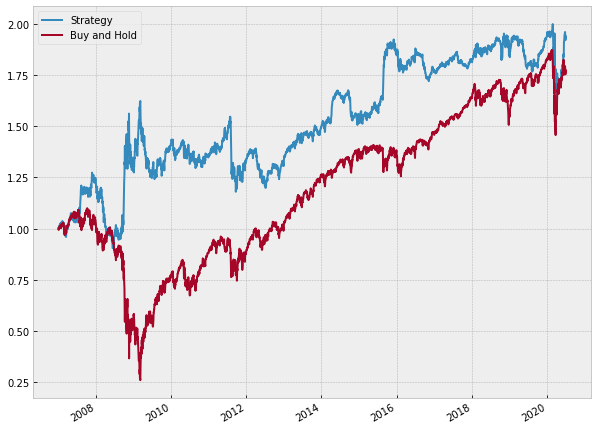

In [106]:
rets = pd.DataFrame(index = signal.index, columns=['Buy and Hold', 'Strategy'])
rets['Buy and Hold'] = lrets[-foreLength:]
rets['Strategy'] = signal
rets['Strategy'] = rets['Strategy']*rets['Buy and Hold']

eqCurves = pd.DataFrame(index = signal.index, columns=['Buy and Hold', 'Strategy'])
eqCurves['Buy and Hold']=rets['Buy and Hold'].cumsum()+1
eqCurves['Strategy'] = rets['Strategy'].cumsum()+1
eqCurves['Strategy'].plot(figsize=(10,8))
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()